## Parametros

In [1]:
lab_enc = True
ohe = True

new_features = True

add_tags = True
add_names = False

parse_warranty = True

is_pdp_pred = False

top_cat_count = 10

RETRAIN_W2V = False
w2v_dim = 300

reduce_dim_pca = False
pca_dims = 100

cluster_sellers = False

prep_data = True

In [2]:
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

test_count_equals_eval_count = False
oversample_true_conversions = False
balance_labels = False

In [3]:
hp_tune = False

In [4]:
random_state = 12345

## Columnas del dataset (Nombre y Descripcion)

- accepts_mercadopago Whether the item accepts Mercado Pago
- available_quantity The available stock quantity at that moment
- avg_asp_item_bday Average selling price of this item over the last days
- avg_asp_item_domain Average price of items of the domain this item belongs to
- avg_asp_item_sel Average price of seller sales
- avg_gmv_item_bday average revenue generated by the item per day
- avg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month
- avg_gmv_item_sel Average revenue of items of this seller
- avg_gmv_seller_bday Average revenue this seller makes by day
- avg_orders_item_bday Average number of orders this item has by day
- avg_orders_seller_bday Average orders the seller has by day
- avg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month
- avg_qty_orders_item_sel_30days Average number of orders an item of this seller makes on the last 30 days
- avg_si_item_bday Average units sold this item has by day
- avg_si_item_sel_30day Average units sold of an item of this seller on the past month
- avg_visits_item Average visits this item had
- benefit Ignore, should be dropped
- boosted Whether the item was boosted
- buy_server_timestamp Timestamp of the purchase
- category_id Category of this item
- conversion Target variable, it is True if this print has an attributed order
- cus_cust_id Buyer id
- cus_cust_id_sel Seller id
- date Print date
- deal_print_id Unique id for the print
- decimals Ignore, will be dropped
- domain_id Domain id for the item
- etl_version Ignore, should be dropped
- free_shipping Whether the item has free shipping
- fulfillment Whether the item is fulfilled by MeLi
- full_name Category full name
- health Item health
- is_pdp Whether the click landed on a PDP
- product_id Product_id of the item
- item_id ID of the item, useful for debugging
- listing_type_id Whether the item is gold or not
- logistic_type Logistic type for the item
- main_picture URL for the main item picture
- offset On which page the item was rendered
- original_price Price from which the discount was done
- platform Which platform the user is using
- price Item price
- print_position Position on the page
- print_server_timestamp Timestamp for the print
- qty_items_dom Number of items this domain has
- qty_items_sel Number of items the seller has
- rn Leftover from the ETL, Discard
- ROW_ID Row of the submission file
- site_id Site ID
- sold_quantity Number of items sold at the moment of the print
- tags Tags the item had at the moment of the print
- title Item title
- total_asp_item_domain_30days Average selling price of the items of the domain
- total_asp_item_sel_30days Average selling price of all the items the seller sold on the last 30 days
- total_gmv_domain_30days Total revenue the domain made on the last 30 days
- total_gmv_domain_bday total_gmv_domain_30days / 30
- total_gmv_item_30days Total revenue made by the item on the lasts 30 days
- total_gmv_seller Total revenue made by the seller on the last month
- total_items_domain Number of items on the domain
- total_items_seller Number of items the seller has
- total_orders_domain_30days Total orders on the domain
- total_orders_item_30days Total orders the Item had on the last 30 days
- total_orders_sel_30days Total orders for the seller
- total_si_domain_30days Total units sold of this domain
- total_si_item_30days Total units sold of this item
- total_si_sel_30days Same for the seller
- total_visits_domain Total visits on this domain
- total_visits_item Total visits this item had
- total_visits_seller Total visits for this seller
- uid session id
- user_id user id
- warranty Whether the item had warranty

## Librerías

In [5]:
from IPython.display import display, Markdown

import pandas as pd

import gc

import os
import sys


from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, HistGradientBoostingClassifier, StackingClassifier, BaggingClassifier

from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score

from sklearn.metrics import roc_auc_score,  roc_curve, auc

from sklearn.cluster import KMeans

import xgboost as xgb

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK


import numpy as np

import matplotlib.pyplot as plt

import itertools

import re

from datetime import datetime


from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pacmap

import nltk

nltk.download('stopwords')
nltk.download('punkt')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
[nltk_data] Downloading package stopwords to /Users/nacho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nacho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [77]:
from jupyter_save_load_vars import savevars, loadvars

## Funciones

In [175]:
def plot_roc_curves(models, model_names, X_test, y_test, ax=None):
    """ Plotea las curvas ROC de los modelos estimadores pasados por parámetro

    Args:
        models (List[Model]): Lista de modelos estimadores
        model_names (List[str]): Lista de nombres de los modelos estimadores
        X_test (pd.DataFrame): DataFrame de features de test
        y_test (pd.DataFrame): DataFrame de labels de test
        ax (matplotlib.axes._subplots.AxesSubplot): Eje sobre el cual graficar (Optional)
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    for i in range(len(models)):
        fpr, tpr, thresholds = roc_curve(y_test, models[i].predict_proba(X_test)[:, models[i].classes_ == 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label=model_names[i] + ' (area = %0.5f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([-0.05, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('ROC Curves de cada modelo estimador')

    # Show grid
    plt.grid(True)

    # plt.legend(loc="lower right")

    # Sort legend by area under curve
    ax.legend(
        *zip(*sorted(
            zip(
                ax.get_legend_handles_labels()[0],
                ax.get_legend_handles_labels()[1]
            ),
            key=lambda x: float(x[1].split(" ")[-1][:-1]),
            reverse=True
        ))
    )

    plt.show()

In [7]:
def notify(title, text):
    """ Muestra una notificación en macOS

    Args:
        title (str): Título de la notificación
        text (str): Texto de la notificación
    """

    if 'darwin' in sys.platform:
        os.system("""
                osascript -e 'display notification "{}" with title "{}"'
                """.format(text, title))

In [8]:
def display_colnames(df):
    """ Muestra los nombres de las columnas de un DataFrame
    
    Args:
        df (pd.DataFrame): DataFrame del cual mostrar los nombres de las columnas
    """
    display(
    Markdown(
        "\n".join(
            [
                "- **{}**".format(col) for col in df.columns
            ]
        )
    )
)

In [ ]:
def save_state():
    # Save Notebook State

    savevars("states/models_backup")

    dfs_backup = pd.HDFStore('states/pandas_backup.h5')

    # save all pandas dataframes from globals

    for var in dict(globals()):
        if isinstance(globals()[var], pd.DataFrame):
            dfs_backup[var] = globals()[var]
    dfs_backup.close()

def load_state():
    # Load Notebook State

    loadvars("states/models_backup")

    dfs_backup = pd.HDFStore('states/pandas_backup.h5')

    # load all pandas dataframes from globals

    for var in dfs_backup.keys():
        globals()[var] = dfs_backup[var]
    dfs_backup.close()

## Load Data

In [9]:
comp_data = pd.read_csv("data/competition_data.csv")
comp_data.head()

,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses,NaN
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días,NaN
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días,NaN


comp_data.describe()

In [45]:
display_colnames(comp_data)

- **accepts_mercadopago**
- **available_quantity**
- **avg_gmv_item_domain_30days**
- **avg_gmv_item_sel**
- **avg_gmv_seller_bday**
- **avg_qty_orders_item_domain_30days**
- **avg_qty_orders_item_sel_30days**
- **avg_si_item_sel_30day**
- **benefit**
- **boosted**
- **category_id**
- **conversion**
- **date**
- **deal_print_id**
- **domain_id**
- **etl_version**
- **free_shipping**
- **fulfillment**
- **full_name**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **main_picture**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **print_server_timestamp**
- **qty_items_dom**
- **qty_items_sel**
- **site_id**
- **sold_quantity**
- **tags**
- **title**
- **total_asp_item_domain_30days**
- **total_asp_item_sel_30days**
- **total_gmv_domain_bday**
- **total_gmv_item_30days**
- **total_items_domain**
- **total_items_seller**
- **total_orders_domain_30days**
- **total_orders_item_30days**
- **total_orders_sel_30days**
- **total_si_domain_30days**
- **total_si_item_30days**
- **total_si_sel_30days**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **uid**
- **user_id**
- **warranty**
- **ROW_ID**

## Data Clean-up

In [10]:
cols_to_drop = [
    "accepts_mercadopago", # Todos tienen mercadopago
    "boosted", # Ninguno
    "avg_qty_orders_item_domain_30days",
    "deal_print_id",
    "etl_version",
    "full_name",
    "main_picture",
    "print_server_timestamp",
    "uid",
    "avg_gmv_item_domain_30days",
    "site_id",
    "total_gmv_domain_bday", 
    "total_items_seller", 
    "total_orders_domain_30days", 
    "total_orders_item_30days", 
    "total_si_sel_30days", 
    "total_asp_item_domain_30days",
    "total_gmv_item_30days",
    "total_si_domain_30days",
    "total_si_item_30days",
]

# Columnas necesarias para clusterizar sellers
if not cluster_sellers:
    cols_to_drop += [
        "avg_qty_orders_item_sel_30days",
        "avg_si_item_sel_30day",
        "total_orders_sel_30days", 
        "total_asp_item_sel_30days", 
        "avg_gmv_seller_bday"
    ]


comp_data = comp_data.drop(columns=cols_to_drop)

### Tags

In [11]:
tags = []

In [12]:
# Parseo de tags

if add_tags:
    if len(tags) == 0:
        tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").explode().value_counts()
        
    for tag in tags.index:
        comp_data[tag] = comp_data["tags"].str.contains(tag).astype(int)

    comp_data["tags_count"] = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(len)

    comp_data = comp_data.drop("tags", axis=1)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_49212/1838967022.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").explode().value_counts()
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_49212/1838967022.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  comp_data["tags_count"] = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(len)


### Names

In [13]:
names = []

In [14]:
# Parseo de nombres

if add_names:
    if len(names) == 0:
        names = comp_data["full_name"].str.split(" -> ").explode().value_counts().head(20).index

    for name in names:
        comp_data["name_" + name] = comp_data["full_name"].str.contains(name).astype(int)

    comp_data = comp_data.drop("full_name", axis=1)


### Date

In [51]:
# Parseo de Fecha

comp_data["date"] = pd.to_datetime(comp_data["date"])
comp_data["day"] = comp_data["date"].dt.day
comp_data["month"] = comp_data["date"].dt.month
comp_data["dayofweek"] = comp_data["date"].dt.dayofweek
comp_data = comp_data.drop(columns=["date"])

### Warranty

In [15]:
# Parseo de warranty
# warranty_saler: 1 si tiene garantía del vendedor, 0 si no, -1 si no especifica
# warranty_factory: 1 si tiene garantía de fábrica, 0 si no, -1 si no especifica
# warranty_no: 1 si no tiene garantía, 0 si tiene, -1 si no especifica
# warranty_missing: 1 si tiene garantía, 0 si no, -1 si no especifica
# warranty_days: cantidad de días de garantía, -1 si no especifica

comp_data["warranty"] = comp_data["warranty"].str.lower()
comp_data["warranty"] = comp_data["warranty"].str.replace("á", "a")
comp_data["warranty"] = comp_data["warranty"].str.replace("í", "i")

comp_data["warranty_saler"] = comp_data["warranty"].str.contains("vendedor").astype(float)
comp_data["warranty_factory"] = comp_data["warranty"].str.contains("fabrica").astype(float)
comp_data["warranty_no"] = comp_data["warranty"].str.contains("sin garantia").astype(float)
comp_data["warranty_missing"] = (~comp_data["warranty"].isna()).astype(float)
comp_data["warranty_days"] = comp_data["warranty"].str.extract("(\d+) dias").astype(float)

def warranty_duration(warranty):
    if pd.isna(warranty):
        return np.nan
    elif "sin garantia" in warranty:
        return 0
    else:
        if "dias" in warranty:
            matches = re.findall("(\d+) dias", warranty)
            if len(matches) == 0:
                return np.nan
            else:
                return int(matches[0])
        elif "meses" in warranty:
            matches = re.findall("(\d+) meses", warranty)
            if len(matches) == 0:
                return np.nan
            else:
                return int(matches[0]) * 30    
        elif "años" in warranty:
            matches = re.findall("(\d+) años", warranty)
            if len(matches) == 0:
                return np.nan
            else:
                return int(matches[0]) * 365
        else:
            return np.nan


comp_data["warranty_days"] = comp_data["warranty"].apply(warranty_duration)
comp_data["warranty_days_missing"] = (~comp_data["warranty_days"].isna()).astype(float)

# Fill ["warranty_saler", "warranty_factory", "warranty_no", "warranty_days"] -1

comp_data["warranty_saler"] = comp_data["warranty_saler"].fillna(-1)
comp_data["warranty_factory"] = comp_data["warranty_factory"].fillna(-1)
comp_data["warranty_no"] = comp_data["warranty_no"].fillna(-1)
comp_data["warranty_days"] = comp_data["warranty_days"].fillna(-1)

comp_data.drop(columns=["warranty"], inplace=True)

### Binary Cols

In [16]:
comp_data["free_shipping"] = comp_data["free_shipping"].astype(int)
comp_data["fulfillment"] = comp_data["fulfillment"].astype(int)

comp_data["imp_user_id"] = comp_data["user_id"].isna().astype(int)
comp_data["user_id"].fillna(0, inplace=True)
comp_data["user_id"] = comp_data["user_id"].astype(int)

comp_data["listing_type_id"] = comp_data["listing_type_id"].apply(lambda x: 0 if x == "gold_special" else 1)

#### Is Product Detail Page

In [17]:
comp_data["imp_is_pdp"] = comp_data["is_pdp"].isna().astype(int)

In [18]:
# Fill nans en "is_pdp" con valores estimados por XGBoost o con 0

if is_pdp_pred:
    X_is_pdp = comp_data[~comp_data["is_pdp"].isna()].drop(columns=["is_pdp", "conversion"]).select_dtypes(include='number')
    y_is_pdp = comp_data[~comp_data["is_pdp"].isna()][["is_pdp"]].astype(bool)

    X_is_pdp_train, X_is_pdp_test, y_is_pdp_train, y_is_pdp_test = train_test_split(
        X_is_pdp, 
        y_is_pdp,
        test_size=0.2, 
        random_state=42
    )

    model = make_pipeline(
        xgb.XGBClassifier(
            n_jobs=-1,
        )
    )

    model.fit(X_is_pdp_train, y_is_pdp_train)

    y_is_pdp_test = y_is_pdp_test[y_is_pdp_test["is_pdp"] == 1].append(y_is_pdp_test[y_is_pdp_test["is_pdp"] == 0].sample(n=y_is_pdp_test[y_is_pdp_test["is_pdp"] == 1].shape[0], random_state=42))
    X_is_pdp_test = X_is_pdp_test.loc[y_is_pdp_test.index]

    is_pdp_pred_score = roc_auc_score(y_is_pdp_test, model.predict_proba(X_is_pdp_test)[:,1])

    print("is_pdp_pred_score: {}".format(is_pdp_pred_score))

    model.fit(X_is_pdp, y_is_pdp)

    pred_is_pdp = model.predict_proba(comp_data[comp_data["is_pdp"].isna()].drop(columns=["is_pdp", "conversion"]).select_dtypes(include='number'))[:,1]
    comp_data.loc[comp_data["is_pdp"].isna(), "is_pdp"] = pred_is_pdp
    comp_data["is_pdp"] = comp_data["is_pdp"].astype(float)

else:
    comp_data["is_pdp"].fillna(0, inplace=True)
    comp_data["is_pdp"] = comp_data["is_pdp"].astype(int)


### Encoding

In [19]:
if lab_enc:
    # LabelEncoder
    comp_data["platform"] = LabelEncoder().fit_transform(comp_data["platform"]).astype(int)
    comp_data["product_id"] = LabelEncoder().fit_transform(comp_data["product_id"]).astype(int)
    comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
    comp_data["logistic_type"] = LabelEncoder().fit_transform(comp_data["logistic_type"]).astype(int)

if ohe:
    # Small OHE con Top top_cat_count (10) Categories

    cats =  comp_data["category_id"].value_counts().index
    top_cats = comp_data["category_id"].value_counts().index[:top_cat_count]

    for tc in top_cats:
        comp_data["category_id_" + str(tc)] = (comp_data["category_id"] == tc).astype(int) 

### Features Nuevas

In [20]:
if new_features:
    comp_data["price_diff"] = comp_data["price"] - comp_data["original_price"]
    comp_data["price_diff"] = comp_data["price_diff"].apply(lambda x: abs(x)).astype(int)

    comp_data["discount"] = (comp_data["original_price"] - comp_data["price"]) / comp_data["original_price"]
    comp_data["discount"] = comp_data["discount"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["price_ratio"] = comp_data["price"] / comp_data["original_price"]
    comp_data["price_ratio"] = comp_data["price_ratio"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_discount"] = comp_data["discount"].apply(lambda x: 1 if x > 0 else 0)

    comp_data["title_length"] = comp_data["title"].str.len()
    comp_data["title_word_count"] = comp_data["title"].str.split(" ").apply(len)

    comp_data["title_length_word_count"] = comp_data["title_length"] / comp_data["title_word_count"]
    comp_data["title_length_word_count"] = comp_data["title_length_word_count"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["domain_dominance"] = comp_data["sold_quantity"] / comp_data["qty_items_dom"]

### Handle Other Missings

In [21]:
# Muchos samples tenian missings en "avg_gmv_item_sel", "qty_items_dom, "qty_items_sel". 
# "domain_dominance" depende de "qty_items_dom" por lo que también tiene missings.

# Se imputan los missings con la mediana de cada columna

# Se agrega una columna "nan_imputed" que indica si se imputó o no el missing
comp_data["nan_imputed"] = comp_data["avg_gmv_item_sel"].isna().astype(int)

comp_data["avg_gmv_item_sel"] = comp_data["avg_gmv_item_sel"].fillna(comp_data["avg_gmv_item_sel"].median())
comp_data["qty_items_dom"] = comp_data["qty_items_dom"].fillna(comp_data["qty_items_dom"].median())
comp_data["qty_items_sel"] = comp_data["qty_items_sel"].fillna(comp_data["qty_items_sel"].median())
comp_data["domain_dominance"] = comp_data["domain_dominance"].fillna(comp_data["domain_dominance"].median())

### PolynomialFeatures

In [22]:
# Polynomial Features de grado 2 de algunas columnas

poly_attrs = ["print_position", "offset", "discount", "price", "health", "original_price"]

for x in poly_attrs:
    comp_data[x + "2"] = comp_data[x] ** 2

for (x, y) in itertools.combinations(poly_attrs, 2):
    comp_data[x + "2 + " + y + "2"] = comp_data[x] ** 2 + comp_data[y] ** 2


### Word2Vec

In [23]:
# Word2Vec with NLTk

comp_data["tokenized_title"] = comp_data["title"].apply(sent_tokenize)
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [word_tokenize(y) for y in x])
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [[y2 for y2 in y1 if re.compile("[A-Za-z]").search(y2[0])] for y1 in x])
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [[y2.lower() for y2 in y1] for y1 in x])

In [25]:
if RETRAIN_W2V:
        
    stop_words = set(stopwords.words('spanish'))

    w2v_model = Word2Vec(vector_size=w2v_dim,
                                    window=3,
                                    min_count=5,
                                    negative=15,
                                    sample=0.01,
                                    workers=8,
                                    sg=1)
                                                                        
    w2v_model.build_vocab([e2 for e1 in comp_data["tokenized_title"].values for e2 in e1],
                    progress_per=10000)

    w2v_model.train([e2 for e1 in comp_data["tokenized_title"].values for e2 in e1],
                total_examples=w2v_model.corpus_count,
                epochs=30, report_delay=1)

    w2v_model.save("title_w2v.model")

else:
    w2v_model = Word2Vec.load("title_w2v.model")

In [26]:
# Obtención de embeddings de títulos utilizando el modelo Word2Vec
# Se promedian los embeddings de cada palabra del título

comp_data["title_embs"] = comp_data["tokenized_title"].apply(lambda x: np.mean(
    [   
        np.zeros(w2v_model.wv.vector_size) if e2 not in w2v_model.wv 
        else w2v_model.wv.get_vector(e2) if len(e2) > 0 
        else np.zeros(w2v_model.wv.vector_size) 
        for e1 in x for e2 in e1
    ],
    axis=0)
)

In [27]:
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: x[0])

In [ ]:
comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]] = np.array(comp_data["title_embs"].tolist())

#### Display Embeddings

In [191]:
comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]]

,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,...,embeddings_290,embeddings_291,embeddings_292,embeddings_293,embeddings_294,embeddings_295,embeddings_296,embeddings_297,embeddings_298,embeddings_299
0,0.407256,0.346109,0.034703,0.195872,0.105712,-0.096924,-0.086645,0.763543,-0.264425,-0.250102,...,0.048355,0.202031,0.284862,0.279447,-0.106692,0.484675,-0.141178,0.164191,-0.153946,0.044015
1,0.042679,0.285040,-0.085519,0.054269,-0.436977,0.009165,-0.043031,0.918024,0.396576,-0.262409,...,-0.329382,0.585860,-0.075787,0.415753,0.589815,0.373095,0.112062,-0.196132,0.075105,-0.205592
2,-0.140189,0.221102,0.334784,0.663381,-0.193465,0.098738,0.163559,0.354226,0.279351,0.449124,...,-0.069502,-0.015078,0.180559,0.182157,0.445096,0.668092,0.144087,-0.223072,0.156411,0.269213
3,0.270412,0.124530,-0.116732,-0.203255,-0.323604,-0.048130,-0.159898,0.539274,0.206988,-0.055276,...,-0.274872,0.565224,0.358737,0.405583,0.602786,0.236667,0.317710,-0.108944,0.071862,-0.418499
4,0.177160,0.292062,-0.015661,0.067940,-0.138912,-0.243836,-0.062292,0.367834,-0.398819,-0.350346,...,-0.174848,0.222140,0.151210,0.078478,0.247092,0.196130,-0.105131,-0.139780,0.086428,-0.121699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199967,-0.060557,0.086833,-0.055899,0.432190,-0.289145,-0.332855,0.415789,0.651786,-0.046805,-0.163709,...,-0.339807,0.105469,0.433681,0.120821,0.088977,0.233058,0.041193,-0.284257,0.019409,-0.319288
199968,-0.022782,-0.132960,-0.091529,0.444677,-0.515899,-0.142040,0.105987,0.580728,-0.488041,0.226574,...,-0.239526,0.395446,0.367903,0.003991,0.608837,0.322964,-0.000260,-0.403646,0.192786,-0.169928
199969,-0.120085,0.523469,0.212257,0.103961,-0.145219,-0.450245,0.103901,0.687452,-0.217462,-0.370850,...,-0.104306,0.210506,0.166247,0.054639,0.178691,0.089791,0.084518,-0.169389,-0.356164,-0.158580
199970,-0.079217,0.150441,0.177942,-0.019753,-0.168739,0.015797,-0.058106,0.147978,0.160441,0.052064,...,0.177821,0.189710,0.576359,0.444357,-0.023808,0.005769,0.015664,-0.245347,0.143789,-0.290579


### Reduce Dimension of Embeddings with PaCMAP

In [30]:
if reduce_dim_pca:

    # Reducción de dimensionalidad con PCA
    
    pacmap_model = pacmap.PaCMAP(
        n_components = pca_dims,
        verbose = True,
    )
    embs = pacmap_model.fit_transform(comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]].values)

    comp_data[["pacmap_" + str(i) for i in range(pca_dims)]] = embs

    comp_data = comp_data.drop(columns=["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)])

    display(comp_data[["pacmap_" + str(i) for i in range(pca_dims)]])

### Remove Title

In [31]:
comp_data = comp_data.drop(columns=["title_embs", "tokenized_title"])

### Cluster Sellers

In [32]:
if cluster_sellers:

    # Clusterización de sellers a partir de las propiedades de los sellers
    
    known_seller_props = [col for col in comp_data.columns if "sel" in col]

    kmeans = KMeans(n_clusters=50, random_state=12345).fit(
            comp_data[comp_data["ROW_ID"].isna()].dropna(subset=known_seller_props)[known_seller_props]
        )

    comp_data["seller_cluster"] = kmeans.predict(comp_data[known_seller_props].fillna(comp_data[known_seller_props].median()))

### Resulting Features

In [33]:
display_colnames(comp_data)

- **available_quantity**
- **avg_gmv_item_sel**
- **benefit**
- **category_id**
- **conversion**
- **date**
- **domain_id**
- **free_shipping**
- **fulfillment**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **qty_items_dom**
- **qty_items_sel**
- **sold_quantity**
- **title**
- **total_items_domain**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **user_id**
- **ROW_ID**
- **immediate_payment**
- **good_quality_picture**
- **brand_verified**
- **good_quality_thumbnail**
- **cart_eligible**
- **loyalty_discount_eligible**
- **today_promotion**
- **extended_warranty_eligible**
- **ahora-12**
- **deal_of_the_day**
- **dragged_bids_and_visits**
- **incomplete_technical_specs**
- **catalog_listing_eligible**
- **lightning_deal**
- **poor_quality_picture**
- **poor_quality_thumbnail**
- **supermarket_eligible**
- **under_infractions**
- **tags_count**
- **warranty_saler**
- **warranty_factory**
- **warranty_no**
- **warranty_missing**
- **warranty_days**
- **warranty_days_missing**
- **imp_user_id**
- **imp_is_pdp**
- **category_id_MLA109027**
- **category_id_MLA1055**
- **category_id_MLA3724**
- **category_id_MLA1002**
- **category_id_MLA3697**
- **category_id_MLA120350**
- **category_id_MLA5411**
- **category_id_MLA1652**
- **category_id_MLA40012**
- **category_id_MLA414251**
- **price_diff**
- **discount**
- **price_ratio**
- **is_discount**
- **title_length**
- **title_word_count**
- **title_length_word_count**
- **domain_dominance**
- **nan_imputed**
- **print_position2**
- **offset2**
- **discount2**
- **price2**
- **health2**
- **original_price2**
- **print_position2 + offset2**
- **print_position2 + discount2**
- **print_position2 + price2**
- **print_position2 + health2**
- **print_position2 + original_price2**
- **offset2 + discount2**
- **offset2 + price2**
- **offset2 + health2**
- **offset2 + original_price2**
- **discount2 + price2**
- **discount2 + health2**
- **discount2 + original_price2**
- **price2 + health2**
- **price2 + original_price2**
- **health2 + original_price2**
- **embeddings_0**
- **embeddings_1**
- **embeddings_2**
- **embeddings_3**
- **embeddings_4**
- **embeddings_5**
- **embeddings_6**
- **embeddings_7**
- **embeddings_8**
- **embeddings_9**
- **embeddings_10**
- **embeddings_11**
- **embeddings_12**
- **embeddings_13**
- **embeddings_14**
- **embeddings_15**
- **embeddings_16**
- **embeddings_17**
- **embeddings_18**
- **embeddings_19**
- **embeddings_20**
- **embeddings_21**
- **embeddings_22**
- **embeddings_23**
- **embeddings_24**
- **embeddings_25**
- **embeddings_26**
- **embeddings_27**
- **embeddings_28**
- **embeddings_29**
- **embeddings_30**
- **embeddings_31**
- **embeddings_32**
- **embeddings_33**
- **embeddings_34**
- **embeddings_35**
- **embeddings_36**
- **embeddings_37**
- **embeddings_38**
- **embeddings_39**
- **embeddings_40**
- **embeddings_41**
- **embeddings_42**
- **embeddings_43**
- **embeddings_44**
- **embeddings_45**
- **embeddings_46**
- **embeddings_47**
- **embeddings_48**
- **embeddings_49**
- **embeddings_50**
- **embeddings_51**
- **embeddings_52**
- **embeddings_53**
- **embeddings_54**
- **embeddings_55**
- **embeddings_56**
- **embeddings_57**
- **embeddings_58**
- **embeddings_59**
- **embeddings_60**
- **embeddings_61**
- **embeddings_62**
- **embeddings_63**
- **embeddings_64**
- **embeddings_65**
- **embeddings_66**
- **embeddings_67**
- **embeddings_68**
- **embeddings_69**
- **embeddings_70**
- **embeddings_71**
- **embeddings_72**
- **embeddings_73**
- **embeddings_74**
- **embeddings_75**
- **embeddings_76**
- **embeddings_77**
- **embeddings_78**
- **embeddings_79**
- **embeddings_80**
- **embeddings_81**
- **embeddings_82**
- **embeddings_83**
- **embeddings_84**
- **embeddings_85**
- **embeddings_86**
- **embeddings_87**
- **embeddings_88**
- **embeddings_89**
- **embeddings_90**
- **embeddings_91**
- **embeddings_92**
- **embeddings_93**
- **embeddings_94**
- **embeddings_95**
- **embeddings_96**
- **embeddings_97**
- **embeddings_98**
- **embeddings_99**
- **embeddings_100**
- **embeddings_101**
- **embeddings_102**
- **embeddings_103**
- **embeddings_104**
- **embeddings_105**
- **embeddings_106**
- **embeddings_107**
- **embeddings_108**
- **embeddings_109**
- **embeddings_110**
- **embeddings_111**
- **embeddings_112**
- **embeddings_113**
- **embeddings_114**
- **embeddings_115**
- **embeddings_116**
- **embeddings_117**
- **embeddings_118**
- **embeddings_119**
- **embeddings_120**
- **embeddings_121**
- **embeddings_122**
- **embeddings_123**
- **embeddings_124**
- **embeddings_125**
- **embeddings_126**
- **embeddings_127**
- **embeddings_128**
- **embeddings_129**
- **embeddings_130**
- **embeddings_131**
- **embeddings_132**
- **embeddings_133**
- **embeddings_134**
- **embeddings_135**
- **embeddings_136**
- **embeddings_137**
- **embeddings_138**
- **embeddings_139**
- **embeddings_140**
- **embeddings_141**
- **embeddings_142**
- **embeddings_143**
- **embeddings_144**
- **embeddings_145**
- **embeddings_146**
- **embeddings_147**
- **embeddings_148**
- **embeddings_149**
- **embeddings_150**
- **embeddings_151**
- **embeddings_152**
- **embeddings_153**
- **embeddings_154**
- **embeddings_155**
- **embeddings_156**
- **embeddings_157**
- **embeddings_158**
- **embeddings_159**
- **embeddings_160**
- **embeddings_161**
- **embeddings_162**
- **embeddings_163**
- **embeddings_164**
- **embeddings_165**
- **embeddings_166**
- **embeddings_167**
- **embeddings_168**
- **embeddings_169**
- **embeddings_170**
- **embeddings_171**
- **embeddings_172**
- **embeddings_173**
- **embeddings_174**
- **embeddings_175**
- **embeddings_176**
- **embeddings_177**
- **embeddings_178**
- **embeddings_179**
- **embeddings_180**
- **embeddings_181**
- **embeddings_182**
- **embeddings_183**
- **embeddings_184**
- **embeddings_185**
- **embeddings_186**
- **embeddings_187**
- **embeddings_188**
- **embeddings_189**
- **embeddings_190**
- **embeddings_191**
- **embeddings_192**
- **embeddings_193**
- **embeddings_194**
- **embeddings_195**
- **embeddings_196**
- **embeddings_197**
- **embeddings_198**
- **embeddings_199**
- **embeddings_200**
- **embeddings_201**
- **embeddings_202**
- **embeddings_203**
- **embeddings_204**
- **embeddings_205**
- **embeddings_206**
- **embeddings_207**
- **embeddings_208**
- **embeddings_209**
- **embeddings_210**
- **embeddings_211**
- **embeddings_212**
- **embeddings_213**
- **embeddings_214**
- **embeddings_215**
- **embeddings_216**
- **embeddings_217**
- **embeddings_218**
- **embeddings_219**
- **embeddings_220**
- **embeddings_221**
- **embeddings_222**
- **embeddings_223**
- **embeddings_224**
- **embeddings_225**
- **embeddings_226**
- **embeddings_227**
- **embeddings_228**
- **embeddings_229**
- **embeddings_230**
- **embeddings_231**
- **embeddings_232**
- **embeddings_233**
- **embeddings_234**
- **embeddings_235**
- **embeddings_236**
- **embeddings_237**
- **embeddings_238**
- **embeddings_239**
- **embeddings_240**
- **embeddings_241**
- **embeddings_242**
- **embeddings_243**
- **embeddings_244**
- **embeddings_245**
- **embeddings_246**
- **embeddings_247**
- **embeddings_248**
- **embeddings_249**
- **embeddings_250**
- **embeddings_251**
- **embeddings_252**
- **embeddings_253**
- **embeddings_254**
- **embeddings_255**
- **embeddings_256**
- **embeddings_257**
- **embeddings_258**
- **embeddings_259**
- **embeddings_260**
- **embeddings_261**
- **embeddings_262**
- **embeddings_263**
- **embeddings_264**
- **embeddings_265**
- **embeddings_266**
- **embeddings_267**
- **embeddings_268**
- **embeddings_269**
- **embeddings_270**
- **embeddings_271**
- **embeddings_272**
- **embeddings_273**
- **embeddings_274**
- **embeddings_275**
- **embeddings_276**
- **embeddings_277**
- **embeddings_278**
- **embeddings_279**
- **embeddings_280**
- **embeddings_281**
- **embeddings_282**
- **embeddings_283**
- **embeddings_284**
- **embeddings_285**
- **embeddings_286**
- **embeddings_287**
- **embeddings_288**
- **embeddings_289**
- **embeddings_290**
- **embeddings_291**
- **embeddings_292**
- **embeddings_293**
- **embeddings_294**
- **embeddings_295**
- **embeddings_296**
- **embeddings_297**
- **embeddings_298**
- **embeddings_299**

In [34]:
comp_data.to_csv("data/competition_data_preprocessed.csv", index=False)

In [70]:
comp_data = pd.read_csv("data/competition_data_preprocessed.csv")

## Prep Data to Train, Test and Submit

### Separar Datos de Entrenaiento y Datos a Predecir

In [35]:
full_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data = comp_data[comp_data["ROW_ID"].notna()]

full_data = full_data.drop(columns=["ROW_ID"])
eval_data = eval_data.drop(columns=["ROW_ID"])

gc.collect()

0

In [36]:
eval_count = eval_data.shape[0]
eval_count

19211

In [37]:
def create_submission_file(model, feature_cols=[], filename="submission.csv"):
    global comp_data
    global eval_data
    
    if len(feature_cols) == 0:
        feature_cols = model.get_booster().feature_names

    eval_data = comp_data[comp_data["ROW_ID"].notna()]

    # Predict on the evaluation set
    eval_data = eval_data.drop(columns=["conversion"])
    eval_data = eval_data.select_dtypes(include='number')
    y_preds = model.predict_proba(eval_data[feature_cols])[:, model.classes_ == 1].squeeze()

    # Make the submission file
    submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
    submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
    submission_df.to_csv(filename, index=False)

### Train Test Split

In [194]:
# Shuffle
full_data = full_data.sample(frac=1, random_state=19092140).reset_index(drop=True)

# Equiparar cantidad de samples de Test con cantidad de samples de Evaluación (Kaggle)
if test_count_equals_eval_count:
    test_data = full_data.sample(eval_count, random_state=42)
    train_data = full_data.drop(test_data.index)
else:
    train_data, test_data = train_test_split(full_data, test_size=TEST_SIZE, train_size=TRAIN_SIZE, random_state=42)


train_data.shape[0], test_data.shape[0], eval_data.shape[0]

(144608, 36153, 19211)

In [39]:
# Oversample true conversions

if oversample_true_conversions:
    true_conversion = train_data[train_data["conversion"] == True]
    train_data = train_data.append(true_conversion).append(true_conversion)


In [40]:
# Equiparar cantidad de samples de Conversion con cantidad de samples de No Conversion subsampleando No Conversion
if balance_labels:

    count_converts_test = test_data[test_data["conversion"] == True].shape[0]
    count_not_converts_test = test_data[test_data["conversion"] == False].shape[0]
    ratio = count_converts_test / count_not_converts_test

    # From test_data, keep ratio of count_not_converts_test entries

    not_converts = test_data[test_data["conversion"] == False].sample(frac=ratio)

    new_test_data = pd.concat([test_data[test_data["conversion"] == True], not_converts])
    new_test_data["conversion"].value_counts()

    count_converts_train = len(train_data[train_data["conversion"] == True])
    count_not_converts_train = len(train_data[train_data["conversion"] == False])

    ratio = count_converts_train / count_not_converts_train

    # From train_data, keep ratio of count_not_converts_train entries

    not_converts = train_data[train_data["conversion"] == False].sample(frac=ratio)

    new_train_data = pd.concat([train_data[train_data["conversion"] == True], not_converts])

    train_data = new_train_data

In [41]:
train_data = train_data.dropna(subset=["conversion"])
test_data = test_data.dropna(subset=["conversion"])

In [195]:
# Cantidades de samples de Conversion y No Conversion en train_data
train_data["conversion"].value_counts()

0.0    131177
1.0     13431
Name: conversion, dtype: int64

In [196]:
# Cantidades de samples de Conversion y No Conversion en test_data
test_data["conversion"].value_counts()

0.0    32840
1.0     3313
Name: conversion, dtype: int64

### Split X and y

In [43]:
y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion"])
X_train = X_train.select_dtypes(include='number')

y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion"])
X_test = X_test.select_dtypes(include='number')

del train_data
del test_data

gc.collect()

0

### Sub Validation Set

In [44]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.25, train_size=0.75, random_state=42)

In [197]:
y_train_sub.value_counts(), y_val.value_counts()

(0.0    98399
 1.0    10057
 Name: conversion, dtype: int64,
 0.0    32837
 1.0     3315
 Name: conversion, dtype: int64)

## Modelos

### XGBoost (Main Model)

#### XGBoost (Default params, Holdout Sub Validation Set)

In [45]:
xgb_subval_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    eval_metric = 'auc',
    n_jobs=-1,
)

xgb_subval_model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=20)

notify("XGB1", "Done")

xgb_subval_score = roc_auc_score(y_test, xgb_subval_model.predict_proba(X_test)[:, xgb_subval_model.classes_ == 1])
xgb_subval_score

[0]	validation_0-auc:0.86066
[20]	validation_0-auc:0.88328
[40]	validation_0-auc:0.88884
[60]	validation_0-auc:0.89034
[80]	validation_0-auc:0.89130
[99]	validation_0-auc:0.89128


0.8954789989340453

##### Feature Importance

Text(0.5, 1.0, 'Weight')

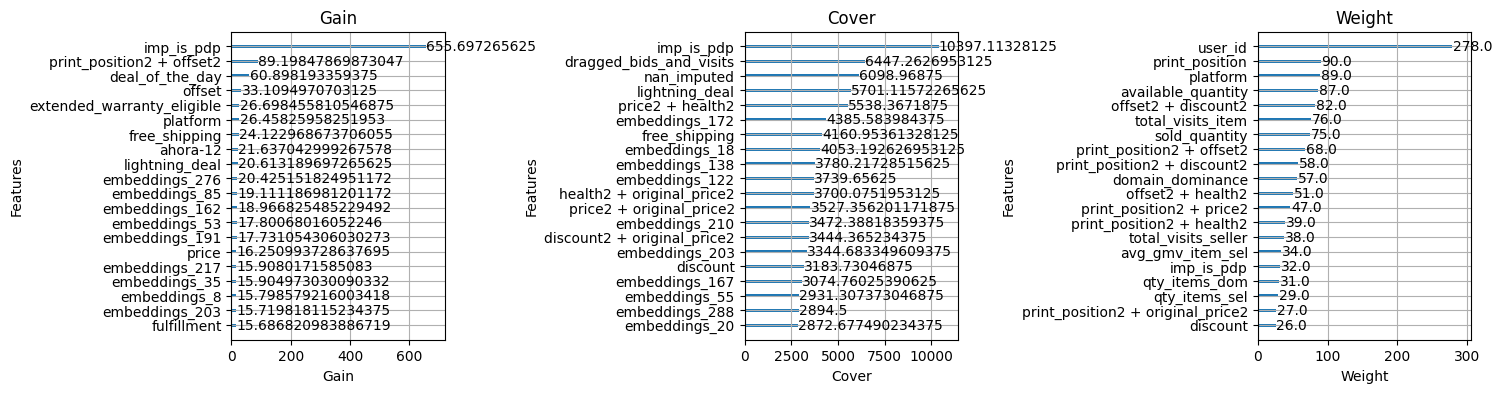

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

xgb.plot_importance(xgb_subval_model, max_num_features=20, importance_type="gain", xlabel="Gain", ax=axs[0])
xgb.plot_importance(xgb_subval_model, max_num_features=20, importance_type="cover", xlabel="Cover", ax=axs[1])
xgb.plot_importance(xgb_subval_model, max_num_features=20, importance_type="weight", xlabel="Weight", ax=axs[2])

fig.subplots_adjust(wspace=1.4)

axs[0].set_title("Gain")
axs[1].set_title("Cover")
axs[2].set_title("Weight")

In [53]:
feature_importances = pd.DataFrame(
    xgb_subval_model.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

In [54]:
gains = sorted(xgb_subval_model.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)
gains_pd = pd.DataFrame(gains, columns=["feature", "gain"]).set_index("feature").sort_values("gain", ascending=False)

In [55]:
reduced_cols = list(set(gains_pd.head(10).index) & set(feature_importances.head(10).index))
reduced_cols

['deal_of_the_day',
 'embeddings_276',
 'platform',
 'extended_warranty_eligible',
 'ahora-12',
 'imp_is_pdp',
 'free_shipping',
 'print_position2 + offset2',
 'lightning_deal',
 'offset']

#### XGBoost (Wrapped 10 most important features)

In [56]:
xgb_wrap_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    n_jobs=-1,
)

xgb_wrap_model.fit(X_train[reduced_cols], y_train)
xgb_wrap_score = roc_auc_score(y_test, xgb_wrap_model.predict_proba(X_test[reduced_cols])[:, xgb_wrap_model.classes_ == 1])

xgb_wrap_score

0.8720407698264875

In [60]:
sub_gains = sorted(xgb_wrap_model.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)
sub_gains_pd = pd.DataFrame(sub_gains, columns=["feature", "gain"]).set_index("feature").sort_values("gain", ascending=False)

sub_gains_pd["original_gain"] = gains_pd["gain"]

sub_gains_pd

,gain,original_gain
feature,,
imp_is_pdp,739.643616,655.697266
lightning_deal,14.814850,20.613190
print_position2 + offset2,10.921257,89.198479
platform,9.682135,26.458260
deal_of_the_day,9.253981,60.898193
offset,8.870365,33.109497
ahora-12,6.638453,21.637043
extended_warranty_eligible,5.543505,26.698456
embeddings_276,4.658874,20.425152


#### XGBoost (Default Params, Cross Validation 5 folds)

In [62]:
xgb_cv_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    n_jobs=-1,
)

scores = cross_val_score(xgb_cv_model, X_train, y_train, cv=5, scoring="roc_auc")

xgb_cv_score = scores.mean()

notify("XGB_CV", "Done. Score: {}".format(xgb_cv_score))

xgb_cv_score

0.8924791915829214

#### XGBoost (Trained with Train + Sub Validation Set)

In [63]:
xgb_model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
        verbosity=1,
)

xgb_model.fit(X_train, y_train)

xgb_ho_score = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, xgb_model.classes_ == 1])

notify("XGB4", "Done. Score: {}".format(xgb_ho_score))

create_submission_file(xgb_model,
                       xgb_model.get_booster().feature_names,
                       "outputs/xgb: {:.5f} {}.csv".format(xgb_ho_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

xgb_ho_score

0.8969727540144464

Text(0.5, 1.0, 'Weight')

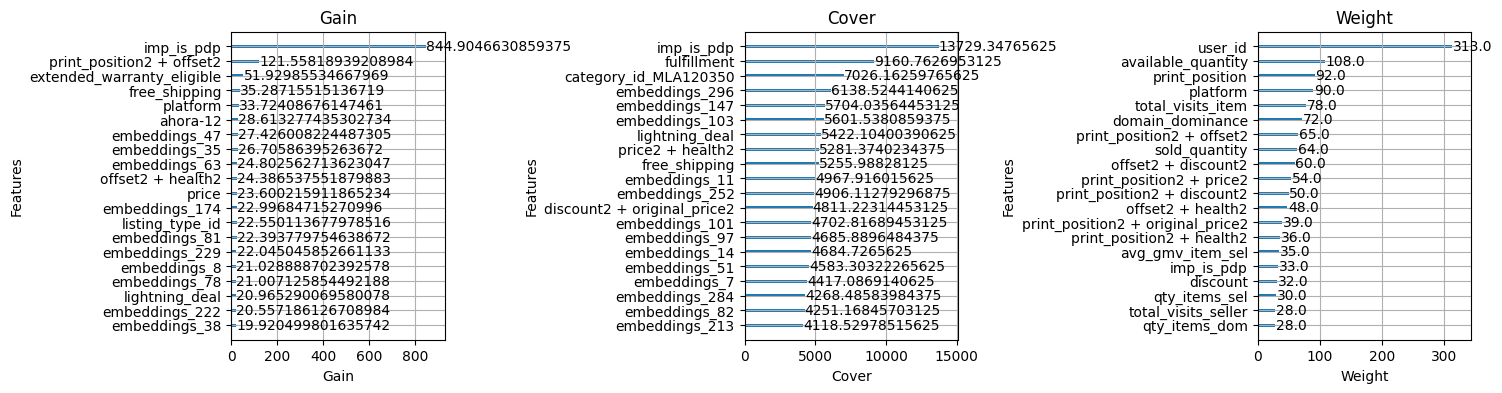

In [210]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

xgb.plot_importance(xgb_model, max_num_features=20, importance_type="gain", xlabel="Gain", ax=axs[0])
xgb.plot_importance(xgb_model, max_num_features=20, importance_type="cover", xlabel="Cover", ax=axs[1])
xgb.plot_importance(xgb_model, max_num_features=20, importance_type="weight", xlabel="Weight", ax=axs[2])

fig.subplots_adjust(wspace=1.4)

axs[0].set_title("Gain")
axs[1].set_title("Cover")
axs[2].set_title("Weight")

### Random Forest Classifier

In [64]:
rfc = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier()
)

rfc.fit(X_train, y_train)

rfc_score = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, rfc.classes_ == 1])
rfc_score

0.836950819564164

### AdaBoost Classifier

In [65]:
abc = make_pipeline(
    SimpleImputer(strategy="median"),
    AdaBoostClassifier()
)

abc.fit(X_train, y_train)

abc_score = roc_auc_score(y_test, abc.predict_proba(X_test)[:, abc.classes_ == 1])

notify("ABC", "Done. Score: {}".format(abc_score))

abc_score

0.8812080135822102

### HistGradientBoosting Classifier

In [66]:
hgb = HistGradientBoostingClassifier(verbose=2)

hgb.fit(X_train, y_train)

score = roc_auc_score(y_test, hgb.predict_proba(X_test)[:, hgb.classes_ == 1])

notify("HGB", "Done. Score: {}".format(score))

score

Binning 0.407 GB of training data: 6.723 s
Binning 0.045 GB of validation data: 0.110 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.28981, val loss: 0.29140, in 0.127s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.27716, val loss: 0.27987, in 0.116s
[3/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.26732, val loss: 0.27091, in 0.104s
[4/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.25951, val loss: 0.26399, in 0.114s
[5/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.25305, val loss: 0.25800, in 0.111s
[6/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.24764, val loss: 0.25289, in 0.109s
[7/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.24297, val loss: 0.24848, in 0.131s
[8/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.23874, val loss: 0.24464, in 0.107s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23519, val loss: 0.24143, in 0.105s
[10/100] 1 tree, 31 leaves, max depth = 10, 

0.8954675096237901

### Otros Modelos Probados (No utilizados en los modelos resultantes)

#### GradientBoosting Classifier

In [67]:
gbc = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier(verbose=2)
)

gbc.fit(X_train, y_train)

gbc_score = roc_auc_score(y_test, gbc.predict_proba(X_test)[:, gbc.classes_ == 1])

notify("GBC", "Done. Score: {}".format(gbc_score))

gbc_score

      Iter       Train Loss   Remaining Time 
         1           0.5884            9.11m
         2           0.5673            9.05m
         3           0.5505            8.95m
         4           0.5366            8.88m
         5           0.5254            9.54m
         6           0.5156            9.32m
         7           0.5073            9.13m
         8           0.5001            8.97m
         9           0.4940            8.83m
        10           0.4886            8.90m
        11           0.4838            8.75m
        12           0.4795            8.80m
        13           0.4757            8.65m
        14           0.4723            8.50m
        15           0.4693            8.37m
        16           0.4667            8.23m
        17           0.4636            8.12m
        18           0.4614            8.15m
        19           0.4591            8.17m
        20           0.4575            8.16m
        21           0.4558            8.16m
        2

0.8831390002447314

#### ExtraTrees Classifier

In [68]:
etc = make_pipeline(
    SimpleImputer(strategy="median"),
    ExtraTreesClassifier()
)

etc.fit(X_train, y_train)

etc_score = roc_auc_score(y_test, etc.predict_proba(X_test)[:, etc.classes_ == 1])

notify("ETC", "Done. Score: {}".format(etc_score))

etc_score

0.8011022672371589

## Modelos de Ensamble

### Average Classifier

A diferencia de la clase VotingClassifier de ScikitLearn, la clase AverageClassifier permite tomar n modelos ya entrenados y promediar sus probas de predicción para obtener una nueva predicción sin entrenar a todos los modelos nuevamente. Lo que no nos permite es tunear los hiperparámetros de todos los modelos a la vez, pero sí nos permite tunear los hiperparámetros de cada modelo por separado.

In [98]:
# average classifier
from sklearn.utils._pprint import _EstimatorPrettyPrinter

class AverageClassifier:
    def __init__(self, models):
        self.models = models
        try:
            self.classes_ = models[0][1].classes_
        except:
            self.classes_ = None

    def predict_proba(self, X):
        return np.mean([model[1].predict_proba(X) for model in self.models], axis=0)

    def predict(self, X):
        return np.mean([model[1].predict(X) for model in self.models], axis=0)

    def fit(self, X, y):
        for name, model in self.models:
            print("Fitting", name)
            model.fit(X, y)
        
        self.classes_ = self.models[0][1].classes_

    def __repr__(self, N_CHAR_MAX=700):
        # N_CHAR_MAX is the (approximate) maximum number of non-blank
        # characters to render. We pass it as an optional parameter to ease
        # the tests.

        # Using _EstimatorPrettyPrinter

        pp = _EstimatorPrettyPrinter(
            compact=True,
            indent=1,
            indent_at_name=True,
            n_max_elements_to_show=N_MAX_ELEMENTS_TO_SHOW,
        )

        repr_ = pp.pformat(self)

        return repr_
        

In [101]:
average_classifier = AverageClassifier(
    [
        ("xgb", xgb.XGBClassifier(
            colsample_bytree = 0.9,
            gamma = 0.5,
            learning_rate = 0.1,
            max_depth = 9,
            min_child_weight = 3,
            n_estimators = 90,
            subsample = 0.9,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
            verbosity=0,
        )),
        ("hgb", HistGradientBoostingClassifier()),
        ("abc", make_pipeline(
            SimpleImputer(strategy="median"),
            AdaBoostClassifier()
        )),
    ]
)

average_classifier.fit(X_train, y_train)

avg_score = roc_auc_score(y_test, average_classifier.predict_proba(X_test)[:, average_classifier.classes_ == 1])

notify("AVG", "Done. Score: {}".format(avg_score))

create_submission_file(average_classifier, 
                       average_classifier.models[0][1].get_booster().feature_names,
                       "outputs/submission_avg(xgb, hgb, abc): {:.5f} {}.csv".format(avg_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

avg_score

0.898707268948252

### Voting Classifier
https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier

Al igual que AverageClassifier, VotingClassifier toma las predicciones de sus estimadores y, si el parámetro voting es 'soft', promedia las probabilidades de predicción de cada estimador. Si el parámetro voting es 'hard', toma la predicción de cada estimador y elige la clase que más votos haya recibido, como nos interesaba la proba predicha, utilizamos 'soft'.

#### Voting(XGBoost, Random Forest)

In [71]:
voting_rfc_xgb = VotingClassifier(
    estimators=[
        ("rfc", rfc),
        ("xgb", xgb.XGBClassifier(
            colsample_bytree = 0.9,
            gamma = 0.5,
            learning_rate = 0.1,
            max_depth = 9,
            min_child_weight = 3,
            n_estimators = 90,
            subsample = 0.9,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
            verbosity=2,
        )),
    ],
    voting="soft",
    n_jobs=-1
)

voting_rfc_xgb.fit(X_train, y_train)

voting_rfc_xgb_score = roc_auc_score(y_test, voting_rfc_xgb.predict_proba(X_test)[:, voting_rfc_xgb.classes_ == 1])

notify("Voting_RFC_XGB", "Done. Score: {}".format(voting_rfc_xgb_score))

voting_rfc_xgb_score

[21:11:46] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=9
[21:11:52] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 2 pruned nodes, max_depth=9
[21:11:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 326 extra nodes, 8 pruned nodes, max_depth=9
[21:12:02] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 298 extra nodes, 6 pruned nodes, max_depth=9
[21:12:08] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

0.8891913879531885

#### Voting(XGBoost, Random Forest, AdaBoost, HistGradientBoosting)

In [72]:
voting_alt = VotingClassifier(
    estimators=[
        ("rfc", rfc),
        ("xgb", xgb.XGBClassifier(
            colsample_bytree = 0.9,
            gamma = 0.5,
            learning_rate = 0.1,
            max_depth = 9,
            min_child_weight = 3,
            n_estimators = 90,
            subsample = 0.9,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
        )),
        ("hgb", hgb),
        ("abc", abc),
    ],
    voting="soft",
    n_jobs=-1,
)

voting_alt.fit(X_train, y_train)

voting_alt_score = roc_auc_score(y_test, voting_alt.predict_proba(X_test)[:, voting_alt.classes_ == 1])

notify("Voting Alt", "Done. Score: {}".format(voting_alt_score))

create_submission_file(voting_alt,
                       voting_alt.estimators_[1].get_booster().feature_names,
                       "outputs/submission_voting(rfc, xgb, hgb, abc): {:.5f}.csv".format(voting_alt_score)
)

voting_alt_score

Binning 0.407 GB of training data: 12.639 s
Binning 0.045 GB of validation data: 0.384 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.28996, val loss: 0.29037, in 0.243s
[2/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.27721, val loss: 0.27783, in 0.240s
[3/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.26757, val loss: 0.26868, in 0.252s
[4/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.25984, val loss: 0.26128, in 0.254s
[5/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.25344, val loss: 0.25542, in 0.220s
[6/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.24804, val loss: 0.25043, in 0.208s
[7/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.24332, val loss: 0.24607, in 0.211s
[8/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23916, val loss: 0.24231, in 0.222s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23547, val loss: 0.23899, in 0.291s
[10/100] 1 tree, 31 leaves, max depth = 11,

0.8999573285207779

In [73]:
voting_alt

VotingClassifier(estimators=[('rfc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('randomforestclassifier',
                                               RandomForestClassifier())])),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.9,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metr...
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=90, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('hgb', HistGradientBoostingClassifier(verbose=2)),
                             ('abc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('adaboostclassifier',
                                               AdaBoostClassifier())]))],
                 n_jobs=-1, voting='soft')

### Stacking Classifier

https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization

In [74]:
stacking_classifier = StackingClassifier(
    estimators=[
        ("rfc", rfc),
        ("xgb", xgb.XGBClassifier(
            colsample_bytree = 0.9,
            gamma = 0.5,
            learning_rate = 0.1,
            max_depth = 9,
            min_child_weight = 3,
            n_estimators = 90,
            subsample = 0.9,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
            verbosity=2,
        )),
        ("hgb", HistGradientBoostingClassifier()),
        ("abc", make_pipeline(
            SimpleImputer(strategy="median"),
            AdaBoostClassifier()
        )),
    ],
    final_estimator=make_pipeline(
        SimpleImputer(strategy="median"),
        LogisticRegression(
            n_jobs=-1,
            max_iter=1000
        )
    ),
    n_jobs=-1,
    stack_method="predict_proba",
    verbose=2
)

stacking_classifier.fit(X_train, y_train)

stack_score = roc_auc_score(y_test, stacking_classifier.predict_proba(X_test)[:, stacking_classifier.classes_ == 1])

notify("STACK", "Done. Score: {}".format(stack_score))

create_submission_file(stacking_classifier,
                        stacking_classifier.named_estimators_["xgb"].get_booster().feature_names,
                       "outputs/submission_stack(rfc, xgb, hgb, abc)->logreg: {:.5f} {}.csv".format(stack_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

stack_score

[21:27:54] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 290 extra nodes, 0 pruned nodes, max_depth=9
[21:28:00] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 302 extra nodes, 2 pruned nodes, max_depth=9
[21:28:06] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 326 extra nodes, 8 pruned nodes, max_depth=9
[21:28:12] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 298 extra nodes, 6 pruned nodes, max_depth=9
[21:28:17] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.2min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.2min finished
[21:41:39] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=9
[21:41:40] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=9
[21:41:41] INFO: /Users/r

0.9000763966758367

In [75]:
stacking_classifier

StackingClassifier(estimators=[('rfc',
                                Pipeline(steps=[('simpleimputer',
                                                 SimpleImputer(strategy='median')),
                                                ('randomforestclassifier',
                                                 RandomForestClassifier())])),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_me...
                               ('hgb', HistGradientBoostingClassifier()),
                               ('abc',
                                Pipeline(steps=[('simpleimputer',
                                                 SimpleImputer(strategy='median')),
                                                ('adaboostclassifier',
                                                 AdaBoostClassifier())]))],
                   final_estimator=Pipeline(steps=[('simpleimputer',
                                                    SimpleImputer(strategy='median')),
                                                   ('logisticregression',
                                                    LogisticRegression(max_iter=1000,
                                                                       n_jobs=-1))]),
                   n_jobs=-1, stack_method='predict_proba', verbose=2)

In [88]:
stacking_classifier_no_rfc = StackingClassifier(
    estimators=[
        ("xgb", xgb.XGBClassifier(
            colsample_bytree = 0.9,
            gamma = 0.5,
            learning_rate = 0.1,
            max_depth = 9,
            min_child_weight = 3,
            n_estimators = 90,
            subsample = 0.9,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
        )),
        ("hgb", HistGradientBoostingClassifier()),
        ("abc", make_pipeline(
            SimpleImputer(strategy="median"),
            AdaBoostClassifier()
        )),
    ],
    final_estimator=make_pipeline(
        SimpleImputer(strategy="median"),
        LogisticRegression(
            n_jobs=-1,
            max_iter=1000
        )
    ),
    n_jobs=-1,
    stack_method="predict_proba",
    verbose=2
)

stacking_classifier_no_rfc.fit(X_train, y_train)

stack_no_rfc_score = roc_auc_score(y_test, stacking_classifier_no_rfc.predict_proba(X_test)[:, stacking_classifier_no_rfc.classes_ == 1])

notify("STACK", "Done. Score: {}".format(stack_no_rfc_score))

create_submission_file(stacking_classifier_no_rfc,
                        stacking_classifier_no_rfc.named_estimators_["xgb"].get_booster().feature_names,
                       "outputs/submission_stack(xgb, hgb, abc)->logreg: {:.5f} {}.csv".format(stack_no_rfc_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

stack_no_rfc_score

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.5min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 10.2min remaining: 15.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.2min finished


0.8985524029973819

In [89]:
stacking_classifier_2 = StackingClassifier(
    estimators=[
        ("xgb", xgb.XGBClassifier(
            colsample_bytree = 0.9,
            gamma = 0.5,
            learning_rate = 0.1,
            max_depth = 9,
            min_child_weight = 3,
            n_estimators = 90,
            subsample = 0.9,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
        )),
        ("hgb", HistGradientBoostingClassifier()),
        ("abc", make_pipeline(
            SimpleImputer(strategy="median"),
            AdaBoostClassifier()
        )),
    ],
    final_estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    n_jobs=-1,
    stack_method="predict_proba",
    verbose=2
)

stacking_classifier_2.fit(X_train, y_train)

stack_xgb_out_score = roc_auc_score(y_test, stacking_classifier_2.predict_proba(X_test)[:, stacking_classifier_2.classes_ == 1])

notify("STACK2", "Done. Score: {}".format(stack_xgb_out_score))

create_submission_file(stacking_classifier_2,
                        stacking_classifier_2.named_estimators_["xgb"].get_booster().feature_names,
                            "outputs/submission_stack(xgb, hgb, abc)->xgb: {:.5f} {}.csv".format(stack_xgb_out_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

stack_xgb_out_score

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.1min remaining: 10.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.1min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.6min remaining: 17.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.6min finished


0.8957494862468975

In [211]:
stacking_classifier_2

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.9,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=0.5,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_ra...
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=-1,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=None, ...),
                   n_jobs=-1, stack_method='predict_proba', verbose=2)

### Average (Voting and Stacking)

In [100]:
average_classifier2 = AverageClassifier([
        ("voting", voting_alt), 
        ("stack", stacking_classifier)
    ]
)

# average_classifier.fit(X_train, y_train)

avg_vot_stack_score = roc_auc_score(y_test, average_classifier2.predict_proba(X_test)[:, average_classifier2.classes_ == 1])

notify("AVG_VOT_STACK", "Done. Score: {}".format(avg_vot_stack_score))

create_submission_file(average_classifier2,
                           #xgb4_model.get_booster().feature_names,
                            average_classifier2.models[0][1].estimators_[1].get_booster().feature_names,
                                "outputs/submission_avg(vot, stack): {:.5f} {}.csv".format(avg_vot_stack_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    )

avg_vot_stack_score

0.9012372105431121

### Bagging Classifier (XGBoost)

In [127]:
bagging_classifier_xgb = BaggingClassifier(
    estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    n_estimators=10,
    n_jobs=-1,
    verbose=20,
)

bagging_classifier_xgb.fit(X_train, y_train)

bag_xgb_score = roc_auc_score(y_test, bagging_classifier_xgb.predict_proba(X_test)[:, bagging_classifier_xgb.classes_ == 1])

notify("BAGGING XGB", "Done. Score: {}".format(bag_xgb_score))

create_submission_file(bagging_classifier_xgb,
                          xgb_model.get_booster().feature_names,
                            "outputs/submission_bagging_xgb_polyfeat: {:.5f} {}.csv".format(bag_xgb_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

bag_xgb_score

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.1s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.7s remaining:    4.6s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.8s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    2.8s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=8

0.9015913481766537

## Tuning de Hiperparámetros

### Random Search sobre XGBoost

In [113]:
xgb_randomized_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    param_distributions={
        "n_estimators": [25, 50, 75, 100, 250, 500],
        "max_depth": [5, 10, 15, 30, 50],
        "learning_rate": [0.001, 0.01, 0.1, 0.2],
        "gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        "min_child_weight": [0, 1, 2, 3, 4, 5, 6],
        "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
        "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
    },
    n_iter=100,
    scoring="roc_auc",
    n_jobs=-1,
    cv=[([t for t in range(int(X_train.shape[0] * 0.8))], [t for t in range(int(X_train.shape[0] * 0.8), X_train.shape[0])])],
    verbose=20
)

xgb_randomized_search.fit(X_train, y_train)

Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV 1/1; 2/100] START colsample_bytree=0.5, gamma=0, learning_rate=0.001, max_depth=5, min_child_weight=0, n_estimators=250, subsample=0.5
[CV 1/1; 1/100] START colsample_bytree=0.5, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=75, subsample=0.5
[CV 1/1; 3/100] START colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=10, min_child_weight=6, n_estimators=75, subsample=0.6
[CV 1/1; 4/100] START colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=30, min_child_weight=6, n_estimators=500, subsample=0.6
[CV 1/1; 5/100] START colsample_bytree=0.7, gamma=0.5, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=75, subsample=0.6
[CV 1/1; 8/100] START colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=50, min_child_weight=6, n_estimators=75, subsample=0.9
[CV 1/1; 6/100] START colsample_bytree=0.8, gamma=0.4, learning_rate=0.01, max_depth=10, min_child_we

/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/1; 36/100] START colsample_bytree=0.9, gamma=0.4, learning_rate=0.2, max_depth=30, min_child_weight=0, n_estimators=25, subsample=0.8
[CV 1/1; 32/100] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.01, max_depth=15, min_child_weight=1, n_estimators=100, subsample=0.7;, score=0.877 total time=14.9min
[CV 1/1; 37/100] START colsample_bytree=0.9, gamma=0.2, learning_rate=0.001, max_depth=15, min_child_weight=6, n_estimators=50, subsample=0.8
[CV 1/1; 36/100] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.2, max_depth=30, min_child_weight=0, n_estimators=25, subsample=0.8;, score=0.881 total time= 8.0min
[CV 1/1; 38/100] START colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=25, subsample=0.9
[CV 1/1; 38/100] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=10, min_child_weight=4, n_estimators=25, subsample=0.9;, score=0.862 total time= 2.4min
[CV 1/1; 39/100] START colsample_bytree=0.6, gamma=0.1, learn

RandomizedSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [115686, 115687, 115688, 115689, 115690, 115691, 115692,
                         115693, 115694, 115695, 115696, 115697, 115698, 115699,
                         115700, 115701, 115702, 115703, 115704, 115705, 115706,
                         115707, 115708, 115709, 115710, 115711, 115712, 115713,
                         115714, 115715, ...])],
                   estimator=XGBClassifie...
                                           predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'max_depth': [5, 10, 15, 30, 50],
                                        'min_child_weight': [0, 1, 2, 3, 4, 5,
                                                             6],
                                        'n_estimators': [25, 50, 75, 100, 250,
                                                         500],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9]},
                   scoring='roc_auc', verbose=20)

In [114]:
xgb_randomized_search.best_params_, xgb_randomized_search.best_score_, xgb_randomized_search.best_estimator_

({'subsample': 0.7,
  'n_estimators': 500,
  'min_child_weight': 1,
  'max_depth': 5,
  'learning_rate': 0.1,
  'gamma': 0.2,
  'colsample_bytree': 0.6},
 0.8918757346342944,
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.6, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               n_estimators=500, n_jobs=-1, num_parallel_tree=None,
               predictor=None, random_state=None, ...))

In [131]:
xgb_randomized_search_best_model = xgb_randomized_search.best_estimator_

xgb_randomized_search_best_model.fit(X_train, y_train)

xgb_rs_score = roc_auc_score(y_test, xgb_randomized_search_best_model.predict_proba(X_test)[:, xgb_randomized_search_best_model.classes_ == 1])

notify("XGB_RAND", "Done. Score: {}".format(xgb_rs_score))

create_submission_file(xgb_randomized_search_best_model,
                          xgb_randomized_search_best_model.get_booster().feature_names,
                          "outputs/xgb_rand: {:.5f} {}.csv".format(xgb_rs_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    ) 

xgb_tuned_model = xgb_randomized_search_best_model
xgb_tuned_score = xgb_rs_score

xgb_tuned_score

0.89995185526668

### Hyperopt sobre XGBoost

In [ ]:
if hp_tune:

    xgb_space = {
        "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
        "n_estimators": hp.choice("n_estimators", [50, 100, 150, 200, 350, 450]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.3, 1),
        "gamma": hp.uniform("gamma", 0, 1),
        "min_child_weight": hp.choice("min_child_weight", [5, 10, 15, 20, 25, 30]),
        "subsample": hp.uniform("subsample", 0.3, 1),
        "eta": hp.uniform("eta", 0.01, 1),
    }

    best_score = 0
    def objective_xgb(params):
        global best_score

        model_opt = xgb.XGBClassifier(
            **params,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
            #eval_metric = 'auc',
        )
        
        # En Colab podemos correr con K-Fold
        # cur_score = cross_val_score(model_opt, X_train, y_train, cv=5, scoring="roc_auc").mean()
        # model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=0)
        
        # Mas rapido, menos fideigno
        model_opt.fit(X_train, y_train)
        cur_score = roc_auc_score(y_test, model_opt.predict_proba(X_test)[:, model_opt.classes_ == 1])

        print(f"Score: {score}", params)

        if cur_score > best_score:
            best_score = cur_score
            print(f"New best score: {best_score}")
            print(params)
            
        return {"loss": 1 - cur_score, "status": STATUS_OK}

    trials_xgb = Trials()

    best_xgb = fmin(
        fn=objective_xgb,
        space=xgb_space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials_xgb,
        verbose=2,
    )

    print(best_xgb)

    xgb_ho = xgb.XGBClassifier(
        **best_xgb.get_params(),
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    )

    xgb_ho.fit(X_train, y_train)
    xgb_ho_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])
    print(xgb_ho_score)

    if xgb_ho_score > xgb_rs_score:
        xgb_tuned_model = xgb_ho
        xgb_tuned_model_score = xgb_ho_score

### Bagging Classifier (XGBoost con Hiperparametros Tuned)

In [133]:
bagging_classifier_xgb_w_best_params = BaggingClassifier(
    estimator=xgb.XGBClassifier(
        **xgb_tuned_model.get_params(),
    ),
    n_estimators=10,
    n_jobs=-1,
    verbose=20,
)

bagging_classifier_xgb_w_best_params.fit(X_train, y_train)

bagging_classifier_xgb_w_best_params_score = roc_auc_score(y_test, bagging_classifier_xgb_w_best_params.predict_proba(X_test)[:, bagging_classifier_xgb_w_best_params.classes_ == 1])

notify("BAGGING XGB", "Done. Score: {}".format(bagging_classifier_xgb_w_best_params_score))

create_submission_file(bagging_classifier_xgb_w_best_params,
                            xgb_model.get_booster().feature_names,
                            "outputs/bagging_xgb_w_best_params: {:.5f} {}.csv".format(bagging_classifier_xgb_w_best_params_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
        )

bagging_classifier_xgb_w_best_params_score

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 32.5min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 32.6min remaining: 97.7min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed: 32.6min remaining: 54.3min


Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed: 32.6min remaining: 32.6min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed: 32.7min remaining: 19.6min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed: 32.7min remaining: 10.9min


Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 48.0min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 48.0min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    6.8s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.8s remaining:    4.7s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.8s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    2.8s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done  

0.9014609173651533

### Random Search sobre Stack (XGBoost, AdaBoost, HistGradientBoosting)

In [ ]:
# RandomizedSearchCV over Stack (XGBClassifier, HGBClassifier, ABCClassifier)

stack_optimized = RandomizedSearchCV(
    estimator=StackingClassifier(
        [
            ("xgb", xgb.XGBClassifier(
                objective = 'binary:logistic',
                seed = random_state,
                n_jobs=-1,
            )),
            ("hgb", HistGradientBoostingClassifier()),
            ("abc", make_pipeline(
                SimpleImputer(strategy="median"),
                AdaBoostClassifier()
            )),
        ],
        final_estimator=xgb.XGBClassifier(
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
        ),
        n_jobs=-1,
        stack_method="predict_proba",
        verbose=2
    ),
    param_distributions={
        "final_estimator__n_estimators": [25, 50, 100],
        "final_estimator__max_depth": [5, 10, 25, 50, 100],
        "final_estimator__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
        "final_estimator__gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        "final_estimator__min_child_weight": [0, 1, 2, 3, 4, 5, 6],
        "final_estimator__subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
        "final_estimator__colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
        "xgb__n_estimators": [25, 50, 100],
        "xgb__max_depth": [5, 10, 25, 50, 100],
        "xgb__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
        "xgb__gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        "xgb__min_child_weight": [0, 1, 2, 3, 4, 5, 6],
        "xgb__subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
        "xgb__colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
        "hgb__max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
        "hgb__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
        "hgb__max_iter": [100, 200, 300, 400, 500],
        "hgb__max_leaf_nodes": [10, 20, 30, 40, 50],
        "hgb__min_samples_leaf": [10, 20, 30, 40, 50],
        "hgb__l2_regularization": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        "abc__adaboostclassifier__n_estimators": [25, 50, 100],
        "abc__adaboostclassifier__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
    },
    n_iter=100,
    scoring="roc_auc",
    n_jobs=-1,
    # Holdout set using [(train_indices, test_indices)] from train_test_split
    cv=[([t for t in range(int(X_train.shape[0] * 0.8))], [t for t in range(int(X_train.shape[0] * 0.8), X_train.shape[0])])],
    verbose=20
)

stack_optimized.fit(X_train, y_train)

stack_optimized_model = stack_optimized.best_estimator_

stack_opt_score = roc_auc_score(y_test, stack_optimized_model.predict_proba(X_test)[:, stack_optimized_model.classes_ == 1])

notify("STACK OPTIMIZED", "Done. Score: {}".format(stack_opt_score))

create_submission_file(stack_optimized_model,
                        stack_opt_score.named_estimators_["xgb"].get_booster().feature_names,
                        "outputs/submission_stack_optimized(xgb, hgb, abc)_polyfeat_imp_pred_pdp_pca_embs: {:.5f} {}.csv".format(stack_opt_score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

stack_opt_score

### Random Search sobre Bagging (XGBoost)

In [ ]:
# RandomizedSearchCV over Bagged XGBClassifier

bagged_xgb_rs = RandomizedSearchCV(
    estimator=BaggingClassifier(
        estimator=xgb.XGBClassifier(
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
        ),
        n_jobs=-1,
        verbose=20,
    ),
    param_distributions={
        "base_estimator__n_estimators": [25, 50, 100],
        "base_estimator__max_depth": [5, 10, 25, 50, 100],
        "base_estimator__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
        "base_estimator__gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        "base_estimator__min_child_weight": [0, 1, 2, 3, 4, 5, 6],
        "base_estimator__subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
        "base_estimator__colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
        "n_estimators": [10, 25, 50, 100],
    },
    n_iter=100,
    scoring="roc_auc",
    n_jobs=-1,
    cv=5,
    verbose=20
)

bagged_xgb_rs.fit(X_train, y_train)

bagged_xgb_rs.best_params_, bagged_xgb_rs.best_score_, bagged_xgb_rs.best_estimator_

## Results

#### Feature Importances

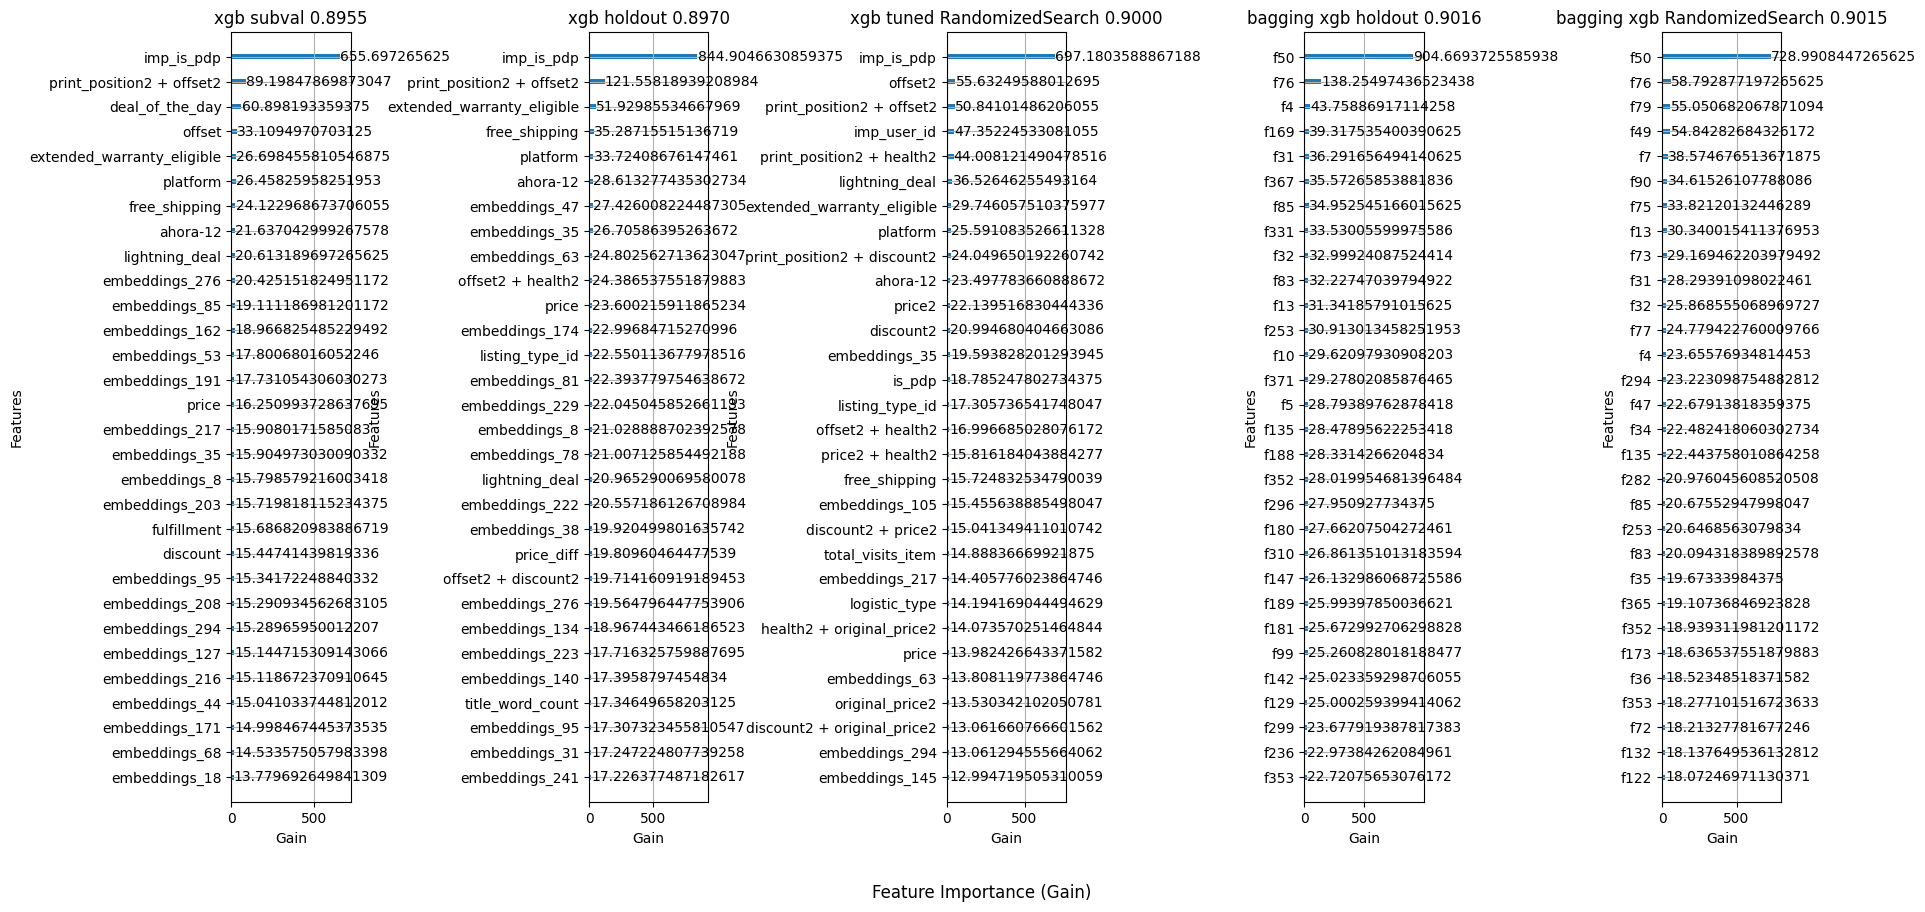

In [206]:
fig, axs = plt.subplots(1, 5, figsize=(20, 10))

feat_count = 30

xgb.plot_importance(xgb_subval_model, max_num_features=feat_count, importance_type="gain", xlabel="Gain", ax=axs[0])
xgb.plot_importance(xgb_model, max_num_features=feat_count, importance_type="gain", xlabel="Gain", ax=axs[1])
xgb.plot_importance(xgb_tuned_model, max_num_features=feat_count, importance_type="gain", xlabel="Gain", ax=axs[2])
xgb.plot_importance(bagging_classifier_xgb.estimators_[0], max_num_features=feat_count, importance_type="gain", xlabel="Gain", ax=axs[3])
xgb.plot_importance(bagging_classifier_xgb_w_best_params.estimators_[0], max_num_features=feat_count, importance_type="gain", xlabel="Gain", ax=axs[4])


# Space between subplots
fig.subplots_adjust(wspace=2)

# Title for each subplot

tune_type = "HyperOpt" if hp_tune else "RandomizedSearch"

axs[0].set_title(f"xgb subval {xgb_subval_score:.4f}".format(xgb_subval_score))
axs[1].set_title(f"xgb holdout {xgb_ho_score:.4f}".format(xgb_ho_score))
axs[2].set_title(f"xgb tuned {tune_type} {xgb_tuned_score:.4f}".format(tune_type, xgb_tuned_score))
axs[3].set_title(f"bagging xgb holdout {bag_xgb_score:.4f}".format(bag_xgb_score))
axs[4].set_title(f"bagging xgb {tune_type} {bagging_classifier_xgb_w_best_params_score:.4f}".format(tune_type, bagging_classifier_xgb_w_best_params_score))

fig.supxlabel("Feature Importance (Gain)")

plt.savefig("outputs/feature_gains_top30.png")

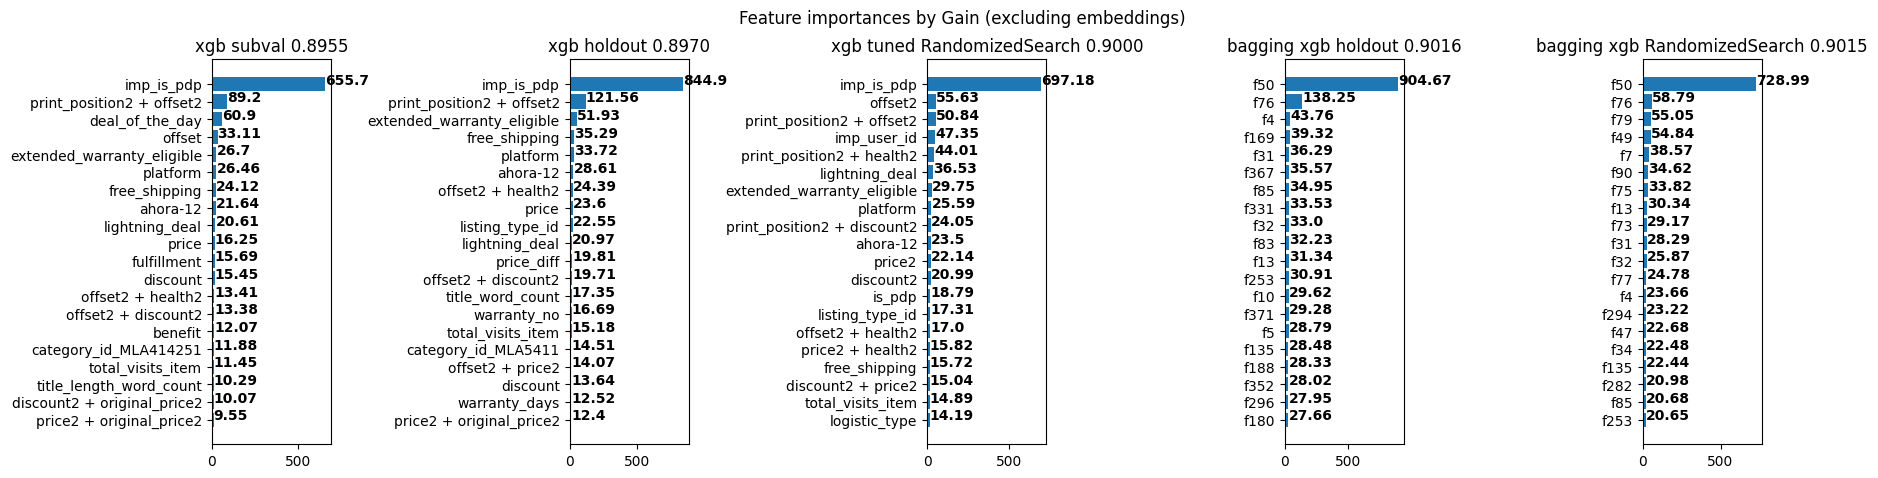

In [204]:
## Feature importances by Gain (excluding embeddings)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

feat_count = 20

gains_sub = sorted(xgb_subval_model.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)
top_gains_sub = pd.DataFrame(gains_sub, columns=["feature", "gain"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

gains_ho = sorted(xgb_model.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)
top_gains_ho = pd.DataFrame(gains_ho, columns=["feature", "gain"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

gains_tuned = sorted(xgb_tuned_model.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)
top_gains_tuned = pd.DataFrame(gains_tuned, columns=["feature", "gain"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

gains_bag = sorted(bagging_classifier_xgb.estimators_[0].get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)
top_gains_bag = pd.DataFrame(gains_bag, columns=["feature", "gain"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

gains_bag_xgb_tuned = sorted(bagging_classifier_xgb_w_best_params.estimators_[0].get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)
top_gains_bag_xgb_tuned = pd.DataFrame(gains_bag_xgb_tuned, columns=["feature", "gain"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

axs[0].barh(top_gains_sub.index[::-1], top_gains_sub["gain"][::-1])
axs[1].barh(top_gains_ho.index[::-1], top_gains_ho["gain"][::-1])
axs[2].barh(top_gains_tuned.index[::-1], top_gains_tuned["gain"][::-1])
axs[3].barh(top_gains_bag.index[::-1], top_gains_bag["gain"][::-1])
axs[4].barh(top_gains_bag_xgb_tuned.index[::-1], top_gains_bag_xgb_tuned["gain"][::-1])


# Plot gains numbers in each bar

for i, v in enumerate(top_gains_sub["gain"][::-1]):
    axs[0].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_gains_ho["gain"][::-1]):
    axs[1].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_gains_tuned["gain"][::-1]):
    axs[2].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_gains_bag["gain"][::-1]):
    axs[3].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_gains_bag_xgb_tuned["gain"][::-1]):
    axs[4].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

# Space between subplots
fig.subplots_adjust(wspace=2)

# Title for each subplot

tune_type = "HyperOpt" if hp_tune else "RandomizedSearch"

axs[0].set_title(f"xgb subval {xgb_subval_score:.4f}".format(xgb_subval_score))
axs[1].set_title(f"xgb holdout {xgb_ho_score:.4f}".format(xgb_ho_score))
axs[2].set_title(f"xgb tuned {tune_type} {xgb_tuned_score:.4f}".format(tune_type, xgb_tuned_score))
axs[3].set_title(f"bagging xgb holdout {bag_xgb_score:.4f}".format(bag_xgb_score))
axs[4].set_title(f"bagging xgb {tune_type} {bagging_classifier_xgb_w_best_params_score:.4f}".format(tune_type, bagging_classifier_xgb_w_best_params_score))

fig.suptitle("Feature importances by Gain (excluding embeddings)")

fig.savefig("plots/feature_gains.png")

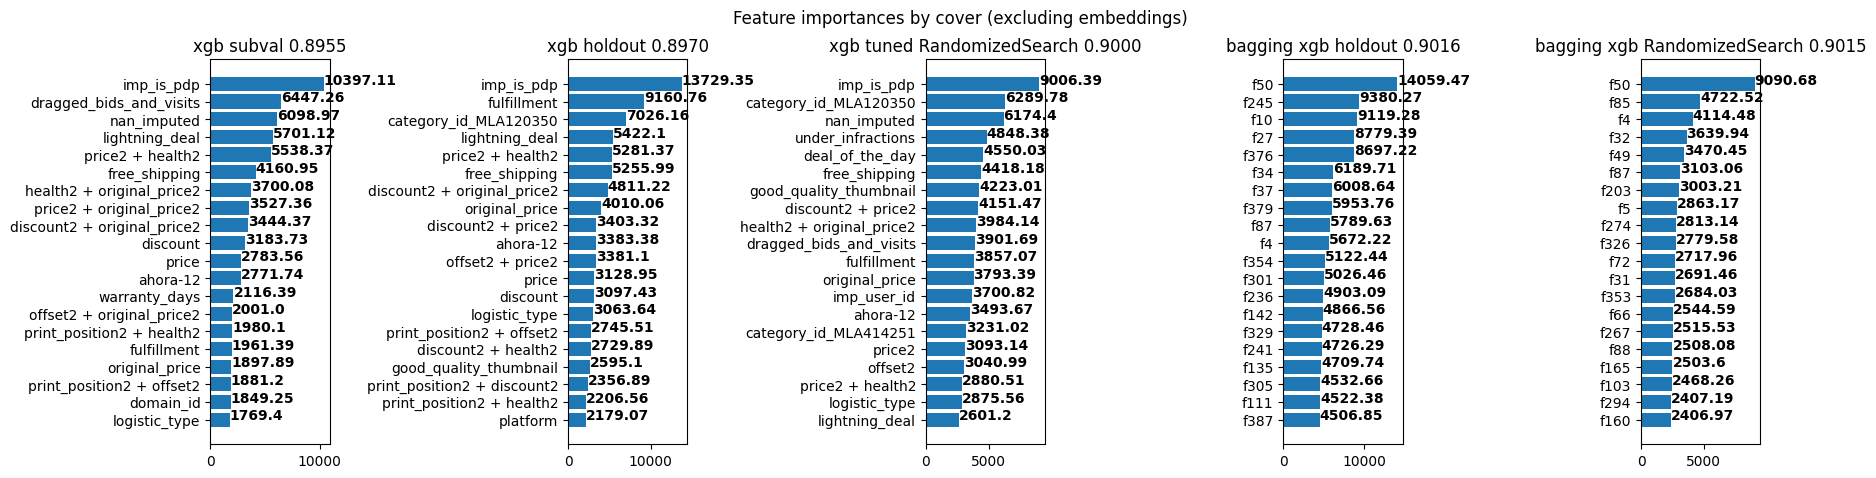

In [203]:
## Feature importances by Cover (excluding embeddings)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

feat_count = 20

covers_sub = sorted(xgb_subval_model.get_booster().get_score(importance_type="cover").items(), key=lambda x: x[1], reverse=True)
top_covers_sub = pd.DataFrame(covers_sub, columns=["feature", "cover"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

covers_ho = sorted(xgb_model.get_booster().get_score(importance_type="cover").items(), key=lambda x: x[1], reverse=True)
top_covers_ho = pd.DataFrame(covers_ho, columns=["feature", "cover"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

covers_tuned = sorted(xgb_tuned_model.get_booster().get_score(importance_type="cover").items(), key=lambda x: x[1], reverse=True)
top_covers_tuned = pd.DataFrame(covers_tuned, columns=["feature", "cover"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

covers_bag = sorted(bagging_classifier_xgb.estimators_[0].get_booster().get_score(importance_type="cover").items(), key=lambda x: x[1], reverse=True)
top_covers_bag = pd.DataFrame(covers_bag, columns=["feature", "cover"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

covers_bag_xgb_tuned = sorted(bagging_classifier_xgb_w_best_params.estimators_[0].get_booster().get_score(importance_type="cover").items(), key=lambda x: x[1], reverse=True)
top_covers_bag_xgb_tuned = pd.DataFrame(covers_bag_xgb_tuned, columns=["feature", "cover"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

axs[0].barh(top_covers_sub.index[::-1], top_covers_sub["cover"][::-1])
axs[1].barh(top_covers_ho.index[::-1], top_covers_ho["cover"][::-1])
axs[2].barh(top_covers_tuned.index[::-1], top_covers_tuned["cover"][::-1])
axs[3].barh(top_covers_bag.index[::-1], top_covers_bag["cover"][::-1])
axs[4].barh(top_covers_bag_xgb_tuned.index[::-1], top_covers_bag_xgb_tuned["cover"][::-1])


# Plot covers numbers in each bar

for i, v in enumerate(top_covers_sub["cover"][::-1]):
    axs[0].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_covers_ho["cover"][::-1]):
    axs[1].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_covers_tuned["cover"][::-1]):
    axs[2].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_covers_bag["cover"][::-1]):
    axs[3].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_covers_bag_xgb_tuned["cover"][::-1]):
    axs[4].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

# Space between subplots
fig.subplots_adjust(wspace=2)

# Title for each subplot

tune_type = "HyperOpt" if hp_tune else "RandomizedSearch"

axs[0].set_title(f"xgb subval {xgb_subval_score:.4f}".format(xgb_subval_score))
axs[1].set_title(f"xgb holdout {xgb_ho_score:.4f}".format(xgb_ho_score))
axs[2].set_title(f"xgb tuned {tune_type} {xgb_tuned_score:.4f}".format(tune_type, xgb_tuned_score))
axs[3].set_title(f"bagging xgb holdout {bag_xgb_score:.4f}".format(bag_xgb_score))
axs[4].set_title(f"bagging xgb {tune_type} {bagging_classifier_xgb_w_best_params_score:.4f}".format(tune_type, bagging_classifier_xgb_w_best_params_score))

fig.suptitle("Feature importances by cover (excluding embeddings)")

fig.savefig("plots/feature_covers.png")

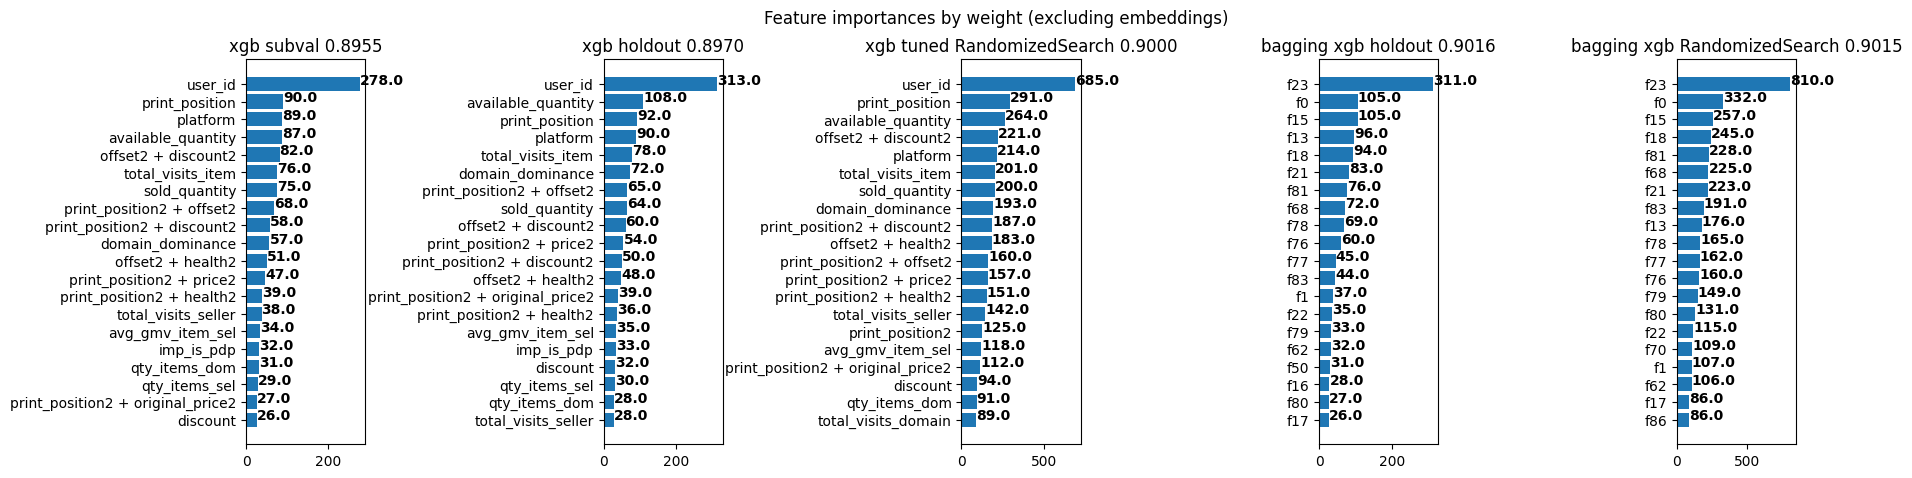

In [202]:
## Feature importances by weight (excluding embeddings)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

feat_count = 20

weights_sub = sorted(xgb_subval_model.get_booster().get_score(importance_type="weight").items(), key=lambda x: x[1], reverse=True)
top_weights_sub = pd.DataFrame(weights_sub, columns=["feature", "weight"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

weights_ho = sorted(xgb_model.get_booster().get_score(importance_type="weight").items(), key=lambda x: x[1], reverse=True)
top_weights_ho = pd.DataFrame(weights_ho, columns=["feature", "weight"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

weights_tuned = sorted(xgb_tuned_model.get_booster().get_score(importance_type="weight").items(), key=lambda x: x[1], reverse=True)
top_weights_tuned = pd.DataFrame(weights_tuned, columns=["feature", "weight"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

weights_bag = sorted(bagging_classifier_xgb.estimators_[0].get_booster().get_score(importance_type="weight").items(), key=lambda x: x[1], reverse=True)
top_weights_bag = pd.DataFrame(weights_bag, columns=["feature", "weight"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

weights_bag_xgb_tuned = sorted(bagging_classifier_xgb_w_best_params.estimators_[0].get_booster().get_score(importance_type="weight").items(), key=lambda x: x[1], reverse=True)
top_weights_bag_xgb_tuned = pd.DataFrame(weights_bag_xgb_tuned, columns=["feature", "weight"]).set_index("feature").filter(regex="^((?!emb).)*$", axis=0).iloc[:feat_count]

axs[0].barh(top_weights_sub.index[::-1], top_weights_sub["weight"][::-1])
axs[1].barh(top_weights_ho.index[::-1], top_weights_ho["weight"][::-1])
axs[2].barh(top_weights_tuned.index[::-1], top_weights_tuned["weight"][::-1])
axs[3].barh(top_weights_bag.index[::-1], top_weights_bag["weight"][::-1])
axs[4].barh(top_weights_bag_xgb_tuned.index[::-1], top_weights_bag_xgb_tuned["weight"][::-1])


# Plot weights numbers in each bar

for i, v in enumerate(top_weights_sub["weight"][::-1]):
    axs[0].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_weights_ho["weight"][::-1]):
    axs[1].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_weights_tuned["weight"][::-1]):
    axs[2].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_weights_bag["weight"][::-1]):
    axs[3].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

for i, v in enumerate(top_weights_bag_xgb_tuned["weight"][::-1]):
    axs[4].text(v + 0.01, i, str(round(v, 2)), color='black', fontweight='bold')

# Space between subplots
fig.subplots_adjust(wspace=2)

# Title for each subplot

tune_type = "HyperOpt" if hp_tune else "RandomizedSearch"

axs[0].set_title(f"xgb subval {xgb_subval_score:.4f}".format(xgb_subval_score))
axs[1].set_title(f"xgb holdout {xgb_ho_score:.4f}".format(xgb_ho_score))
axs[2].set_title(f"xgb tuned {tune_type} {xgb_tuned_score:.4f}".format(tune_type, xgb_tuned_score))
axs[3].set_title(f"bagging xgb holdout {bag_xgb_score:.4f}".format(bag_xgb_score))
axs[4].set_title(f"bagging xgb {tune_type} {bagging_classifier_xgb_w_best_params_score:.4f}".format(tune_type, bagging_classifier_xgb_w_best_params_score))

fig.suptitle("Feature importances by weight (excluding embeddings)")

fig.savefig("plots/feature_weights.png")

### ROC Curves

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.5s remaining:   10.6s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.5s remaining:    5.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    3.5s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    3.6s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    3.6s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    4.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.3s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=8

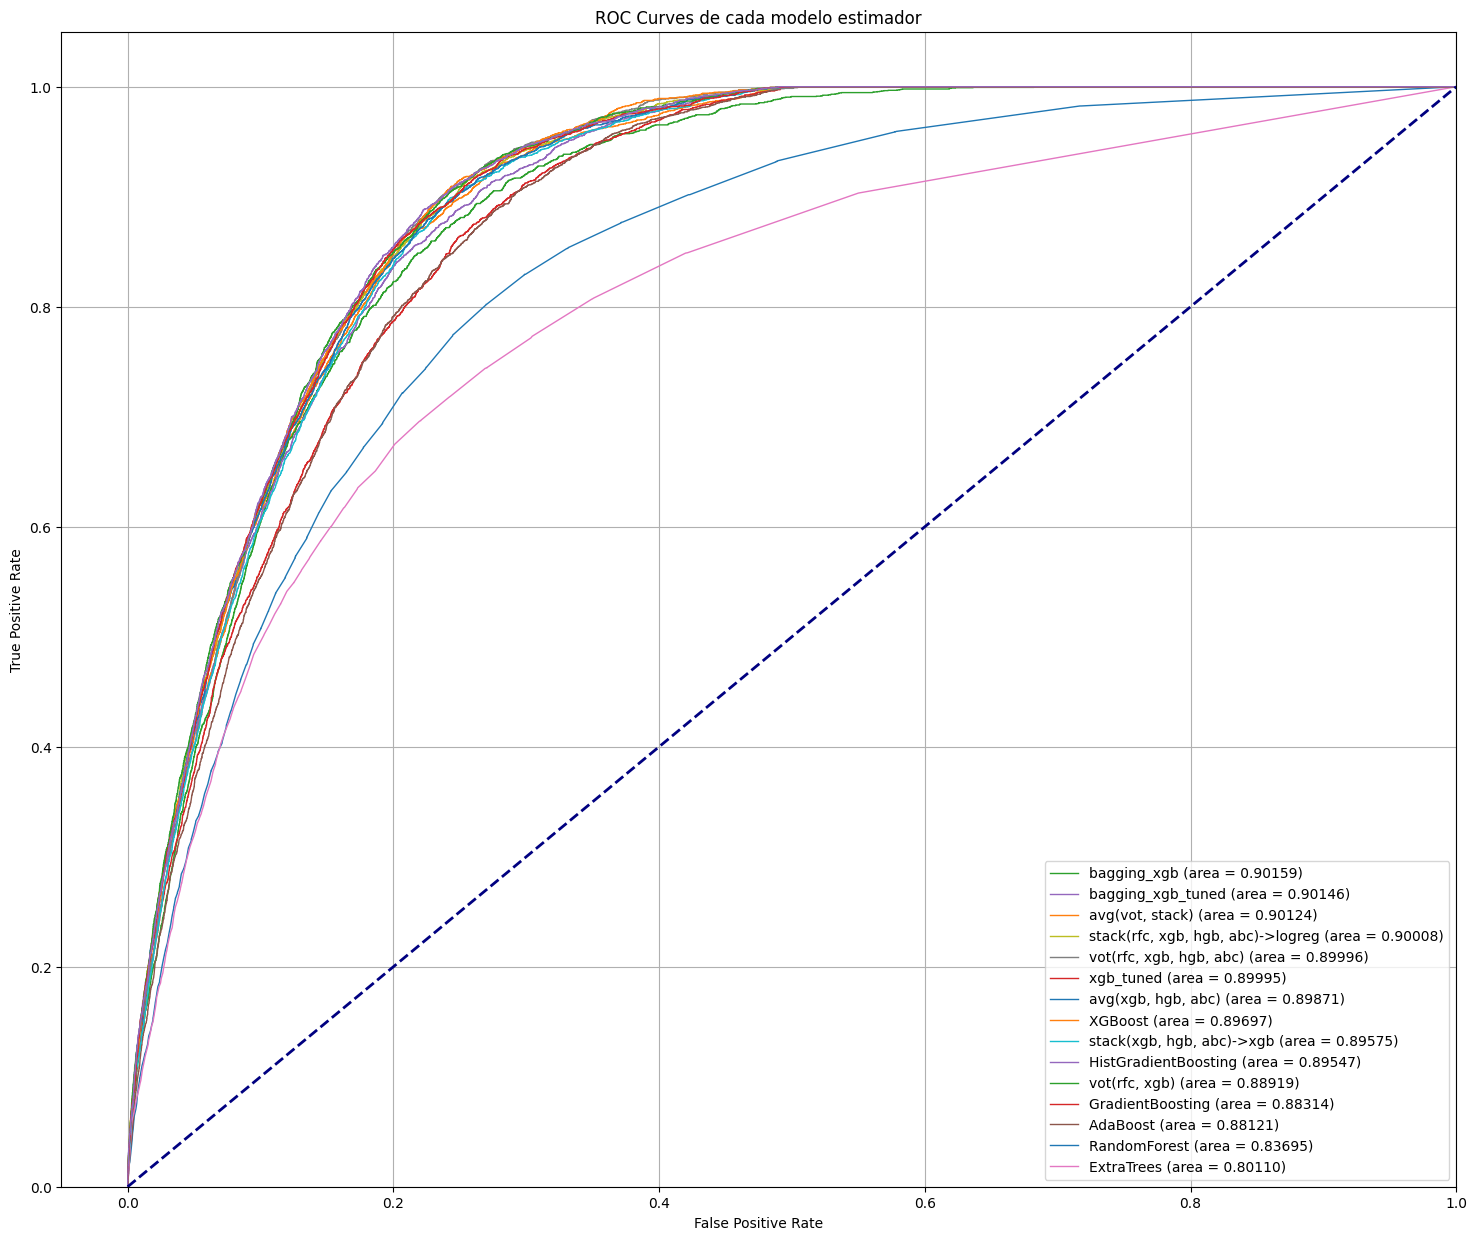

In [200]:
models = [
    (rfc, "RandomForest"),
    (xgb_model, "XGBoost"),
    (voting_rfc_xgb, "vot(rfc, xgb)"),
    (gbc, "GradientBoosting"),
    (hgb, "HistGradientBoosting"),
    (abc, "AdaBoost"),
    (etc, "ExtraTrees"),
    (voting_alt, "vot(rfc, xgb, hgb, abc)"),
    (stacking_classifier, "stack(rfc, xgb, hgb, abc)->logreg"),
    (stacking_classifier_2, "stack(xgb, hgb, abc)->xgb"),
    (average_classifier, "avg(xgb, hgb, abc)"),
    (average_classifier2, "avg(vot, stack)"),
    (bagging_classifier_xgb, "bagging_xgb"),
    # (stack_optimized, "stack_optimized"),
    # (bagged_xgb_rs, "bagged_xgb_rs"),
    (xgb_tuned_model, "xgb_tuned"),
    (bagging_classifier_xgb_w_best_params, "bagging_xgb_tuned"),
]

model_names = [model[1] for model in models]
models = [model[0] for model in models]

fig, ax = plt.subplots(figsize=(18, 15))

plot_roc_curves(models, model_names, X_test, y_test, ax=ax)

fig.tight_layout()

fig.savefig("plots/roc_curves.png")

In [184]:
save_state()

[INFO]: 2023-10-08 14:16:12,087 - saveloadvars - saved to states/models_backup.dill variables [ ] (File "/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/jupyter_save_load_vars.py", line 179, in savevars)
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_49212/2647397225.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['category_id', 'date', 'deal_print_id', 'domain_id', 'etl_version',
       'full_name', 'is_pdp', 'item_id', 'listing_type_id', 'logistic_type',
       'main_picture', 'platform', 'print_server_timestamp', 'site_id', 'tags',
       'title', 'uid', 'warranty'],
      dtype='object')]

  save_state()
